In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model

import numpy as np
import pandas as pd
import os

import random
from collections import deque
import matplotlib.pylab as plt

from sklearn.decomposition import PCA

In [2]:
# TODO: add other metrics: returns, volatility, alpha, beta to the benchmark

# Imports of classes

In [3]:
from environment import ETFEnvironment, CryptoEnvironment
from agent import MinVarianceAgent, MaxSharpeAgent, MaxDecorrelationAgent, MaxReturnsAgent
from utils import *

In [4]:
N_ASSETS = 53
WINDOW_FIT = 180
WINDOW_HOLD = 180
env = ETFEnvironment()

In [5]:
agent_max_returns = MaxReturnsAgent(N_ASSETS, allow_short=True)
agent_minvar = MinVarianceAgent(N_ASSETS, allow_short=True)
agent_maxsharpe = MaxSharpeAgent(N_ASSETS, allow_short=True)
agent_maxdecorr = MaxDecorrelationAgent(N_ASSETS, allow_short=True)

# Reweighting process: optimization

In [6]:
actions_equal, actions_returns, actions_minvar, actions_maxsharpe, actions_maxdecorr = [], [], [], [], []
result_equal, result_returns, result_minvar, result_maxsharpe, result_maxdecorr = [], [], [], [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False)
    
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_minvar = agent_minvar.act(state)
    action_max_returns = agent_max_returns.act(state)
    action_maxsharpe = agent_maxsharpe.act(state)
    action_maxdecorr = agent_maxdecorr.act(state)
 
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_minvar)
    result_minvar.append(r.tolist())
    actions_minvar.append(action_minvar)

    r = np.dot(state_action, action_max_returns)
    result_returns.append(r.tolist())
    actions_returns.append(action_max_returns)
    
    r = np.dot(state_action, action_maxsharpe)
    result_maxsharpe.append(r.tolist())
    actions_maxsharpe.append(action_maxsharpe)
    
    r = np.dot(state_action, action_maxdecorr)
    result_maxdecorr.append(r.tolist())
    actions_maxdecorr.append(action_maxdecorr)

# Evaluation

In [7]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_returns_vis = [item for sublist in result_returns for item in sublist]
result_minvar_vis = [item for sublist in result_minvar for item in sublist]
result_maxsharpe_vis = [item for sublist in result_maxsharpe for item in sublist]
result_maxdecorr_vis = [item for sublist in result_maxdecorr for item in sublist]

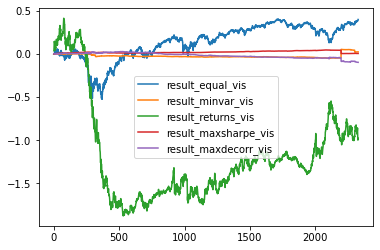

In [8]:
%matplotlib inline

plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'result_equal_vis')
plt.plot(np.array(result_minvar_vis).cumsum(), label = "result_minvar_vis")
plt.plot(np.array(result_returns_vis).cumsum(), label = "result_returns_vis")
plt.plot(np.array(result_maxsharpe_vis).cumsum(), label = "result_maxsharpe_vis")
plt.plot(np.array(result_maxdecorr_vis).cumsum(), label = "result_maxdecorr_vis")
plt.legend(["result_equal_vis", "result_minvar_vis", "result_returns_vis", "result_maxsharpe_vis", "result_maxdecorr_vis"])
plt.show()




In [9]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('MINVAR', print_stats(result_minvar_vis, result_equal_vis))
print('MAXRET', print_stats(result_returns_vis, result_equal_vis))
print('MAXSHRAPE', print_stats(result_maxsharpe_vis, result_equal_vis))
print('MAXDECORR', print_stats(result_maxdecorr_vis, result_equal_vis))

EQUAL [0.0002, 0.0124, 0.2207, 0.0, 1.0]
MINVAR [0.0, 0.0022, 0.0701, 0.0, 0.0038]
MAXRET [-0.0004, 0.0236, -0.294, -0.0004, 0.0709]
MAXSHRAPE [0.0, 0.0009, 0.0247, 0.0, -0.0031]
MAXDECORR [-0.0, 0.0012, -0.5619, -0.0, -0.0284]


# Visualization

In [10]:
import matplotlib
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

In [11]:
def plot_results(benchmark_series, 
                 target_series, 
                 target_balances, 
                 n_assets = N_ASSETS,
                 columns = state.columns,
                 name2plot = '',
                 path2save = './',
                 base_name_series = 'series'):
    
#     N = len(np.array(benchmark_series).cumsum())
    N = len(np.array([item for sublist in benchmark_series for item in sublist]).cumsum()) 
    
    if not os.path.exists(path2save):
        os.makedirs(path2save)

    for i in range(0, len(target_balances)):

        current_range = np.arange(0, N)
        current_ts = np.zeros(N)
        current_ts2 = np.zeros(N)

        ts_benchmark = np.array([item for sublist in benchmark_series[:i+1] for item in sublist]).cumsum()
        ts_target = np.array([item for sublist in target_series[:i+1] for item in sublist]).cumsum()

        t = len(ts_benchmark)
        current_ts[:t] = ts_benchmark
        current_ts2[:t] = ts_target

        current_ts[current_ts == 0] = ts_benchmark[-1]
        current_ts2[current_ts2 == 0] = ts_target[-1]

        plt.figure(figsize = (12, 10))
        
        plt.subplot(2, 1, 1)
        plt.bar(np.arange(n_assets), target_balances[i], color = 'grey')
        plt.xticks(np.arange(n_assets), columns, rotation='vertical')

        plt.subplot(2, 1, 2)
        plt.colormaps = current_cmap
        plt.plot(current_range[:t], current_ts[:t], color = 'black', label = 'Benchmark')
        plt.plot(current_range[:t], current_ts2[:t], color = 'red', label = name2plot)
        plt.plot(current_range[t:], current_ts[t:], ls = '--', lw = .1, color = 'black')
        plt.autoscale(False)
        plt.ylim([-1.5, 1.5])
        plt.legend()
        plt.savefig(path2save + base_name_series + str(i) + '.jpg')

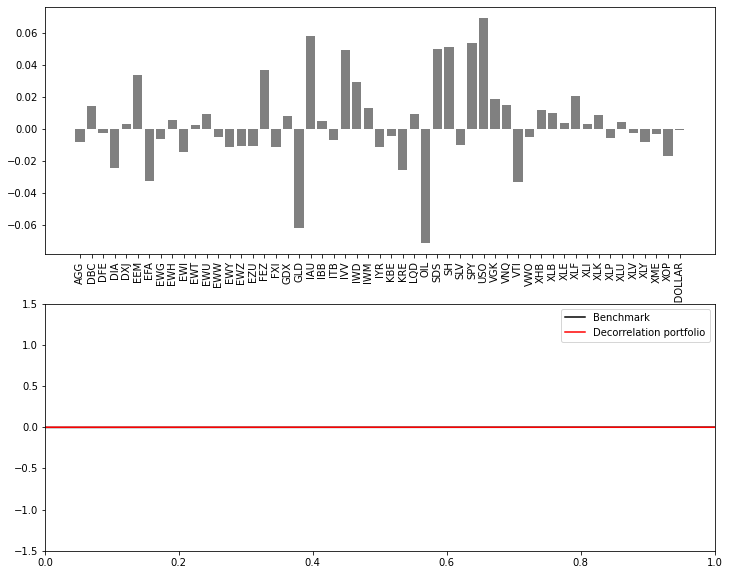

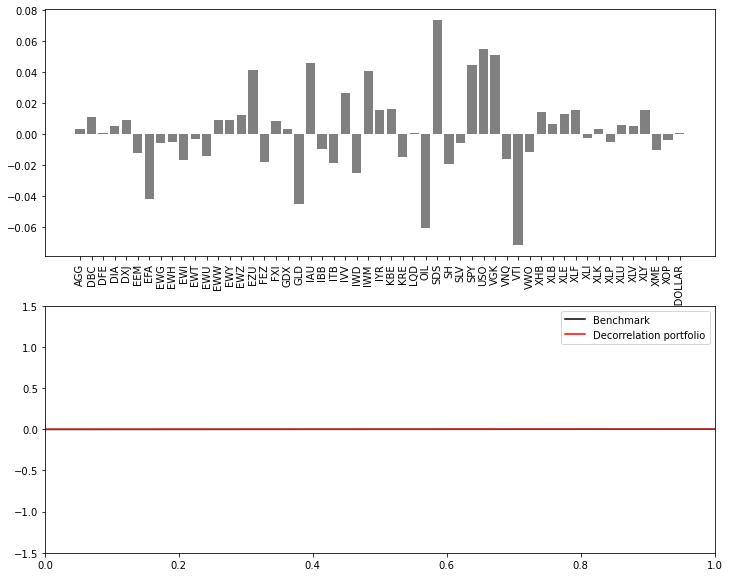

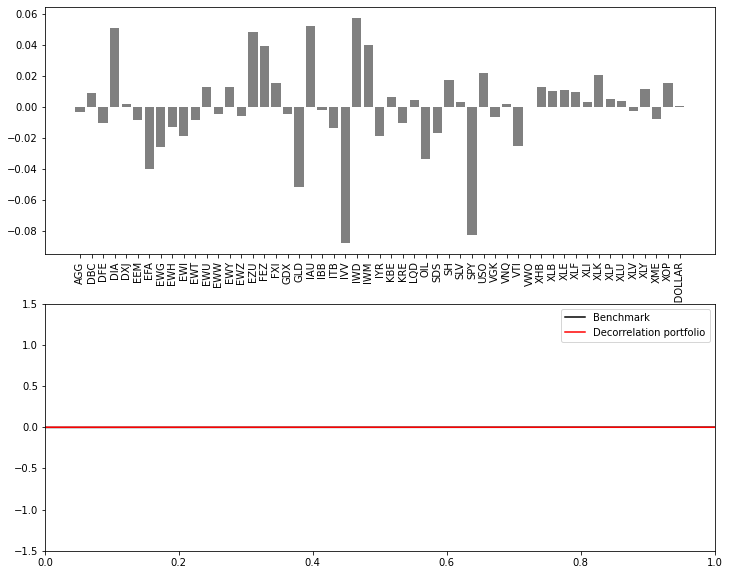

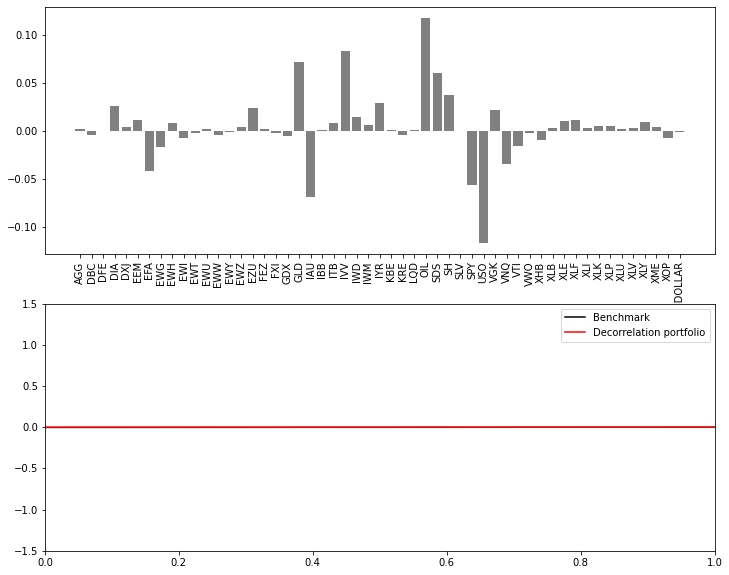

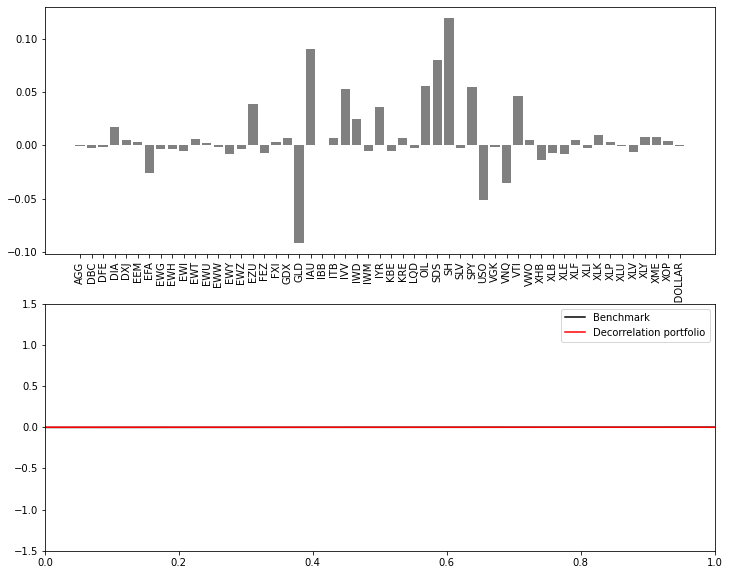

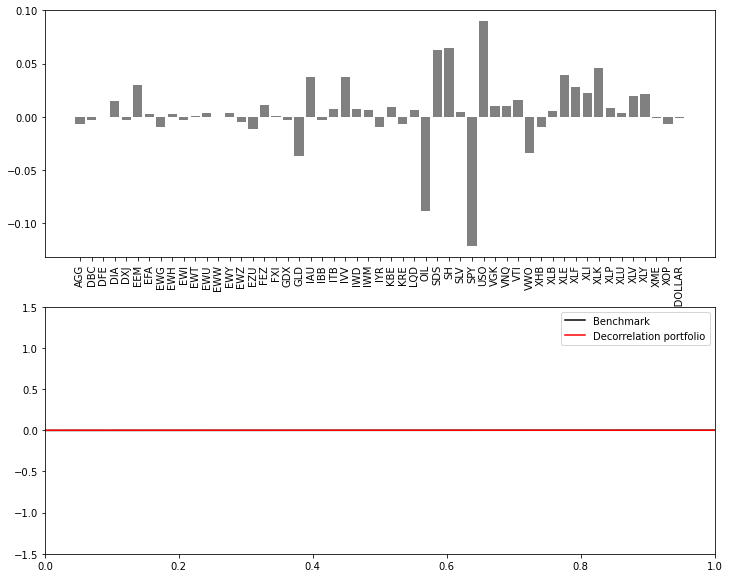

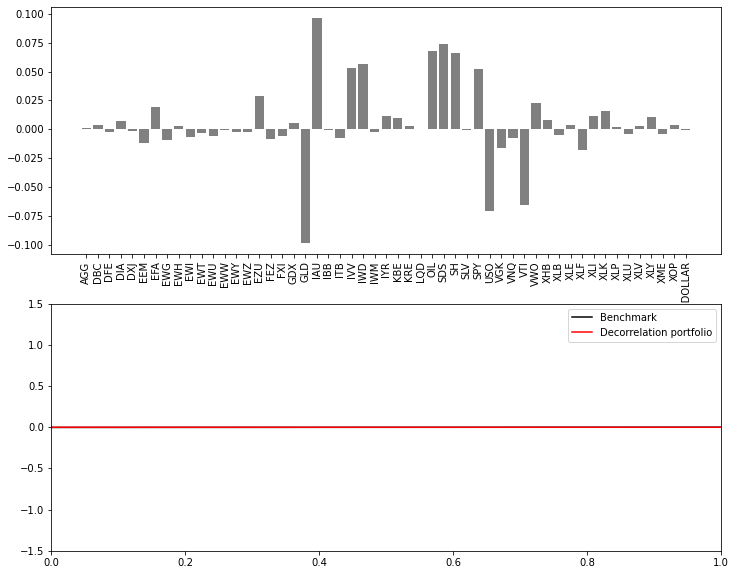

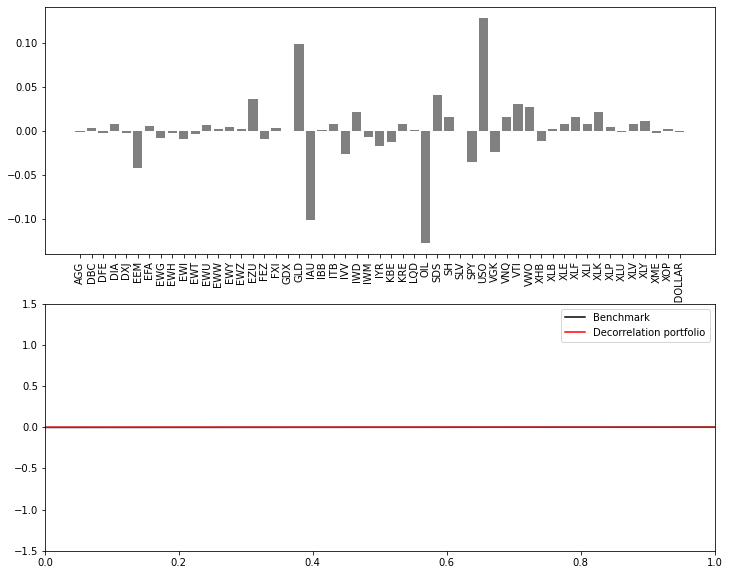

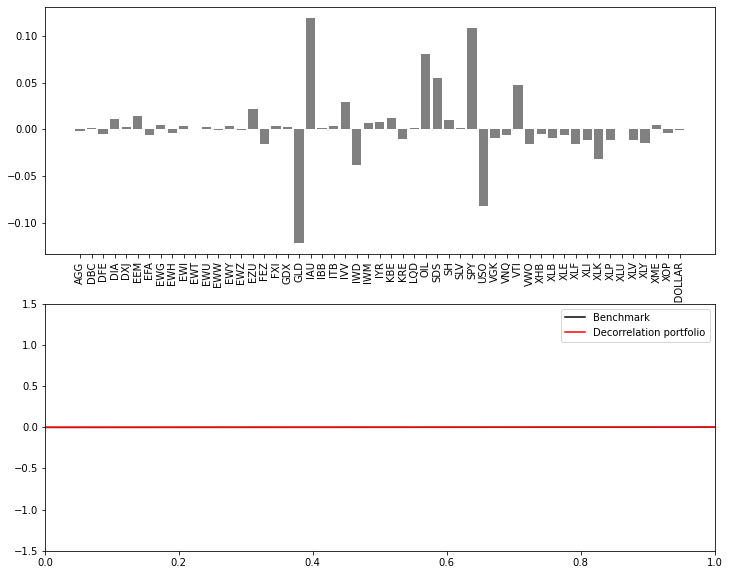

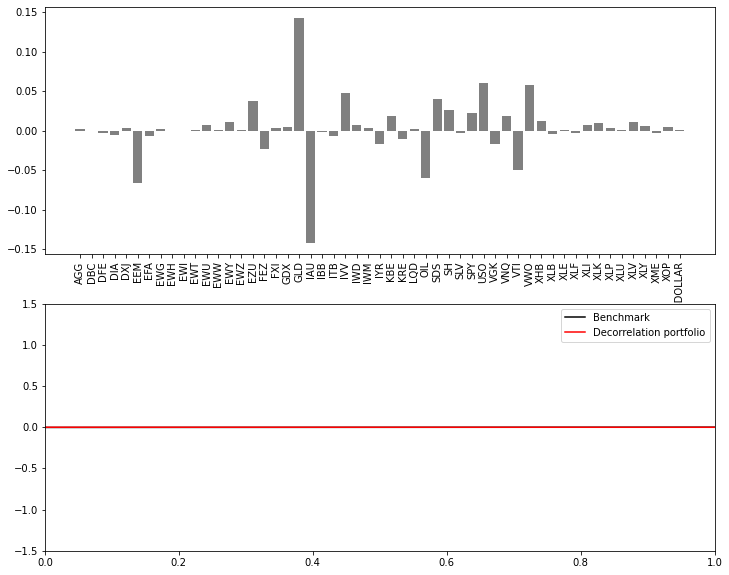

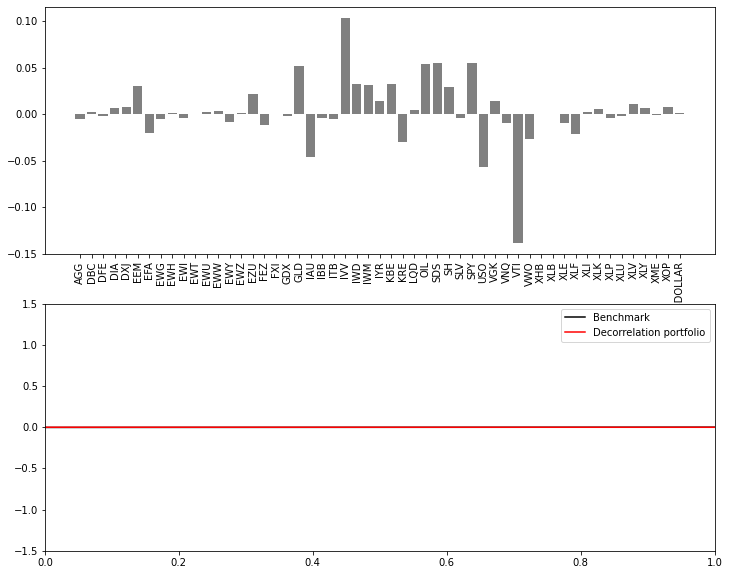

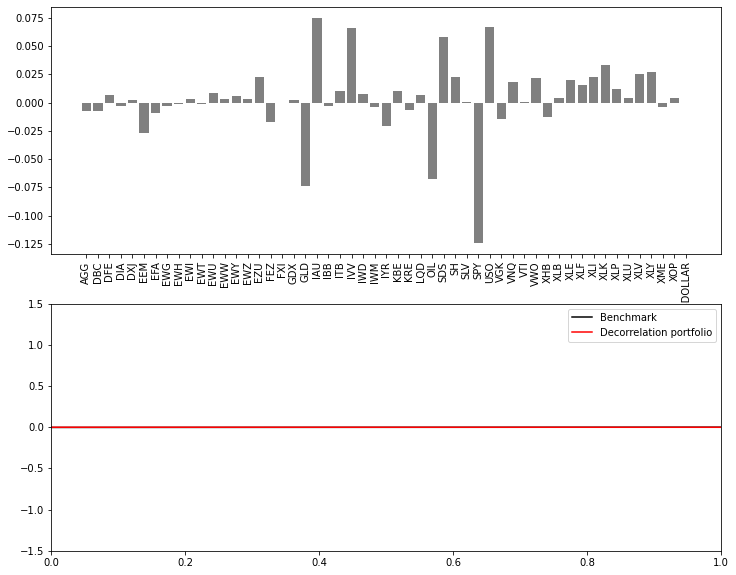

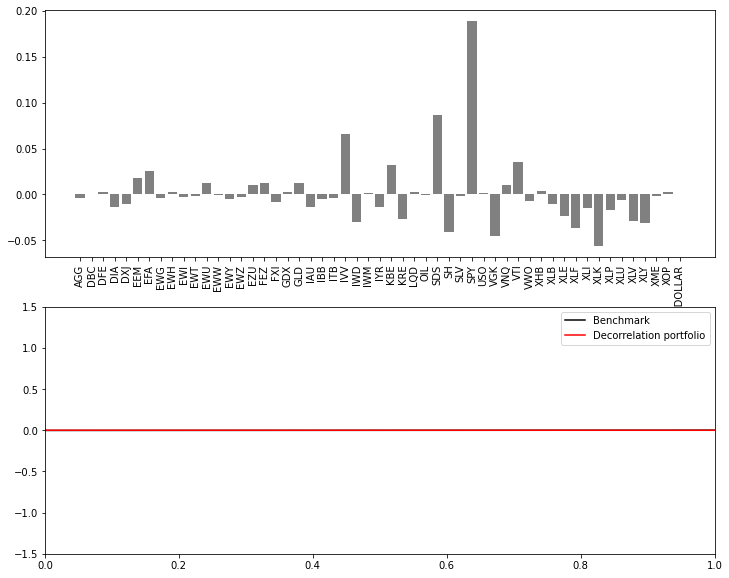

In [12]:
plot_results(result_equal, 
             result_maxdecorr, 
             actions_maxdecorr, 
             N_ASSETS,
             state.columns.tolist(), 
             'Decorrelation portfolio', './images_etf/decorr/', 'series')

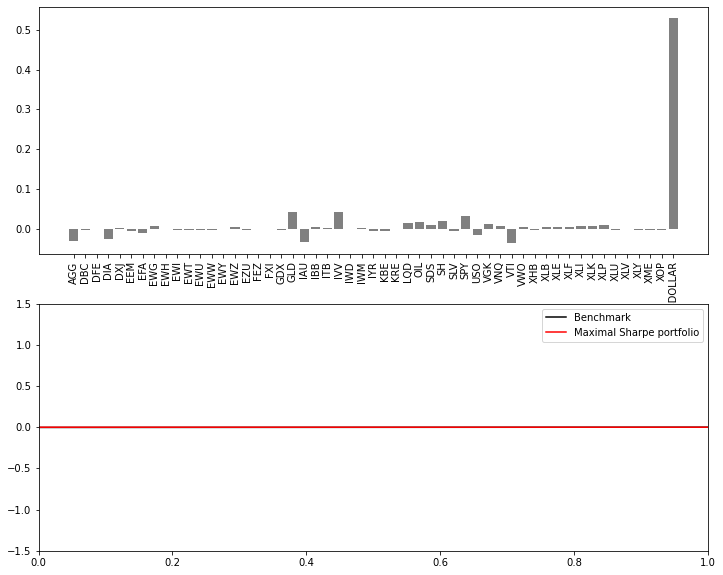

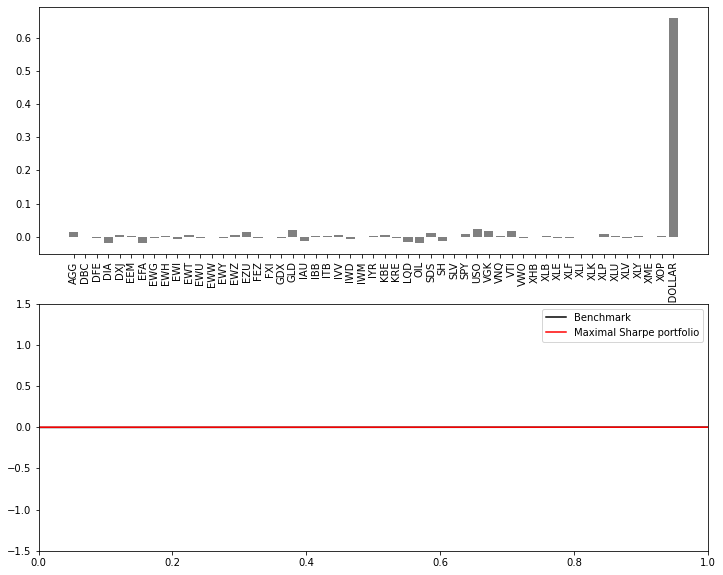

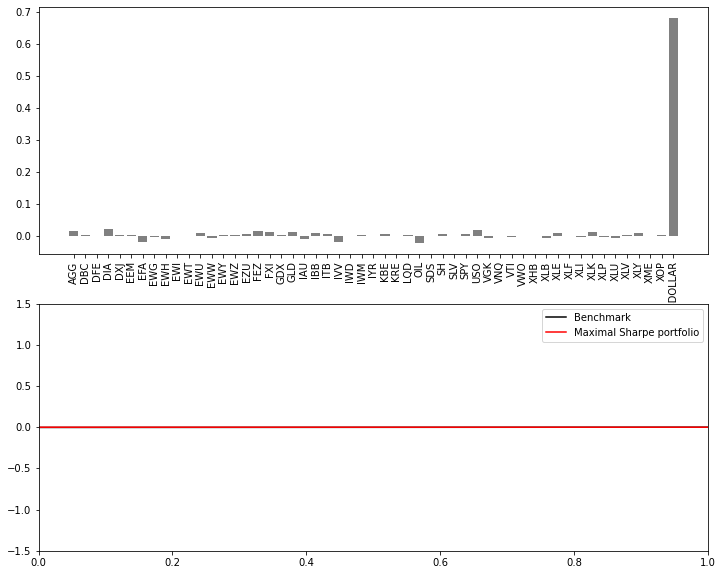

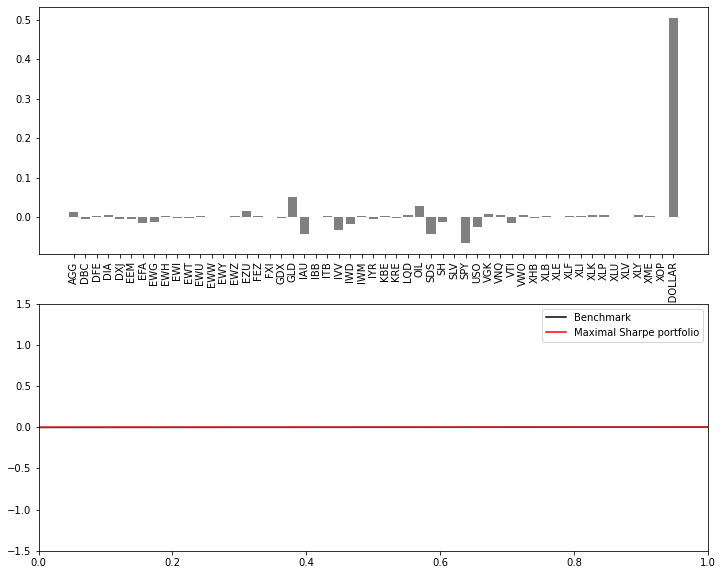

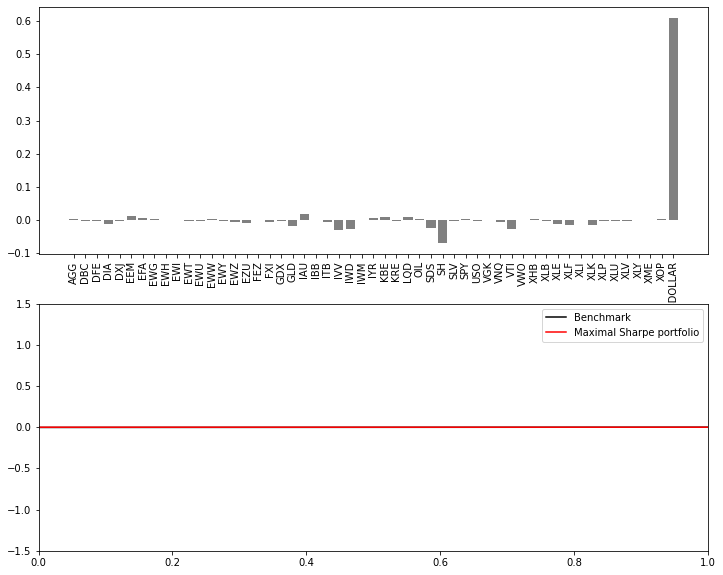

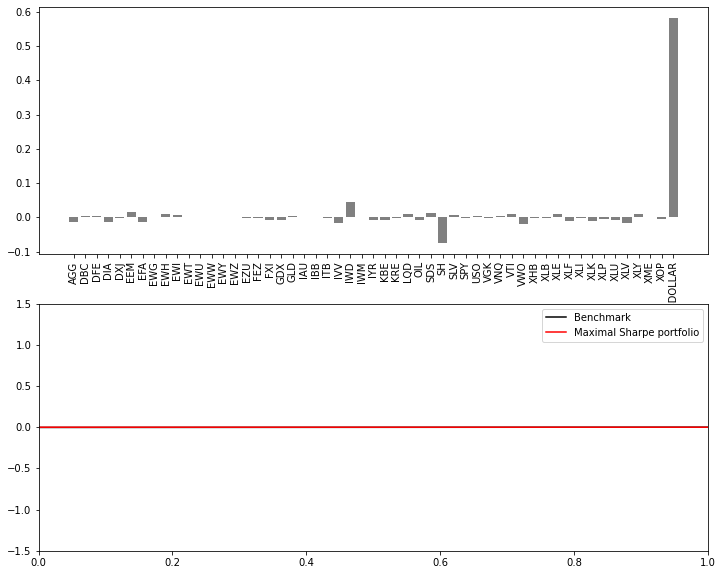

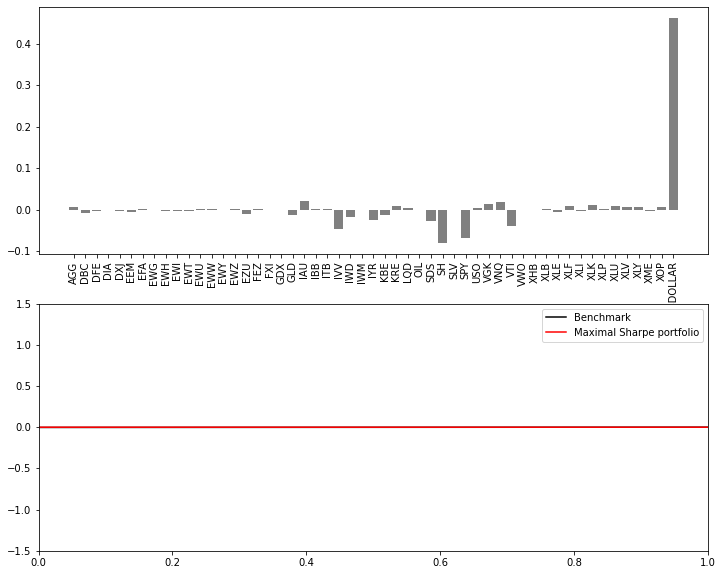

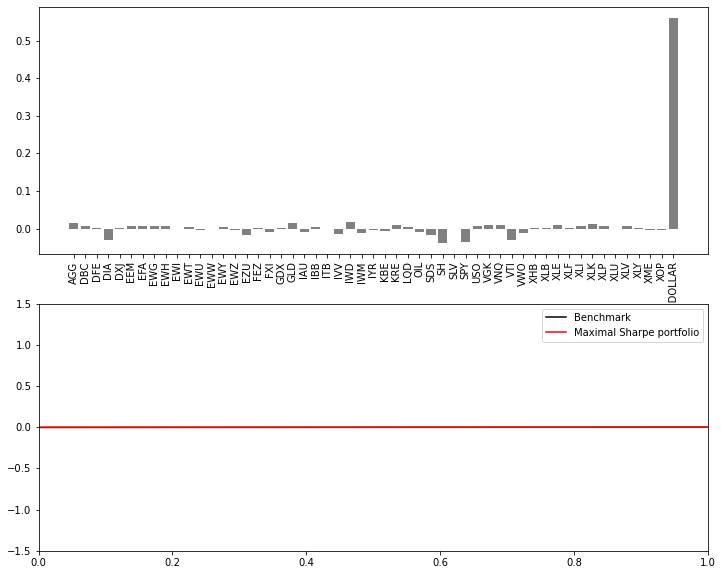

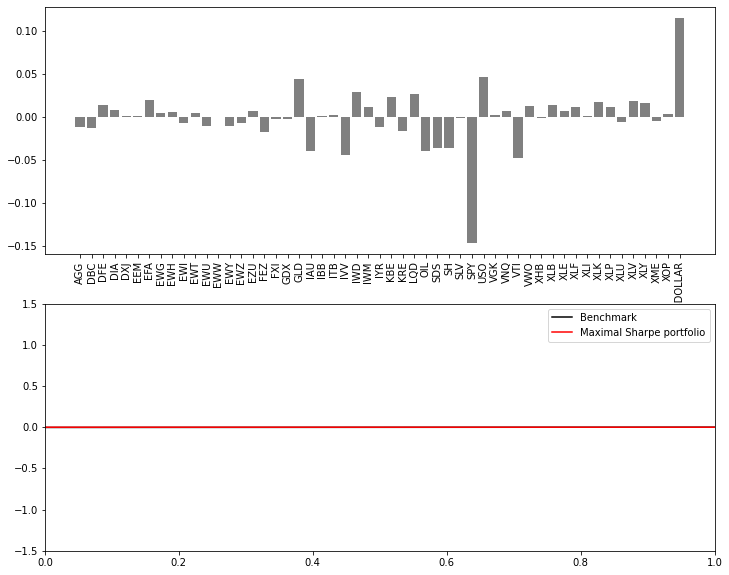

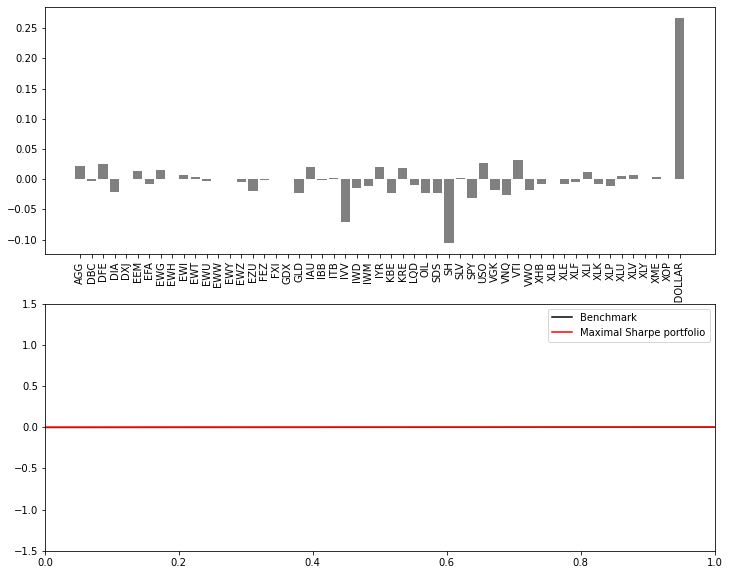

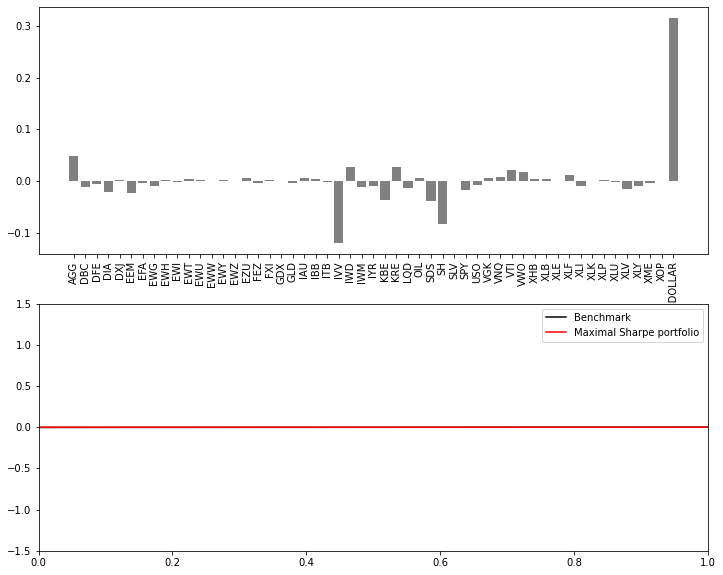

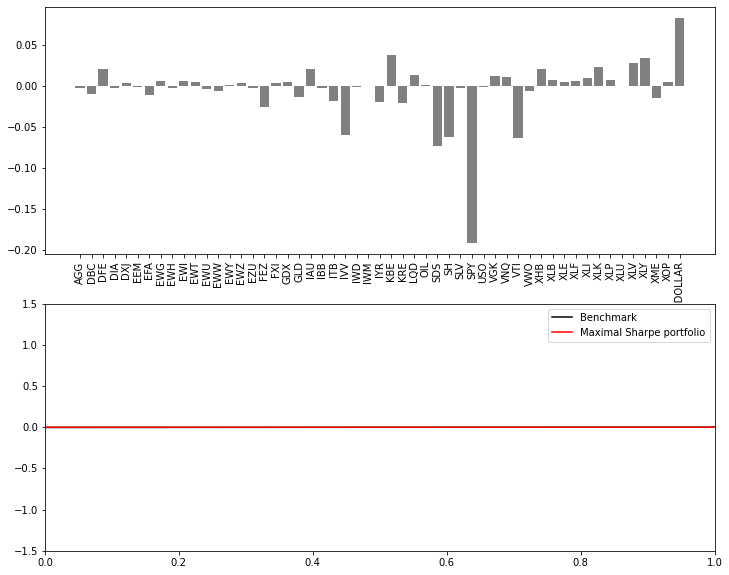

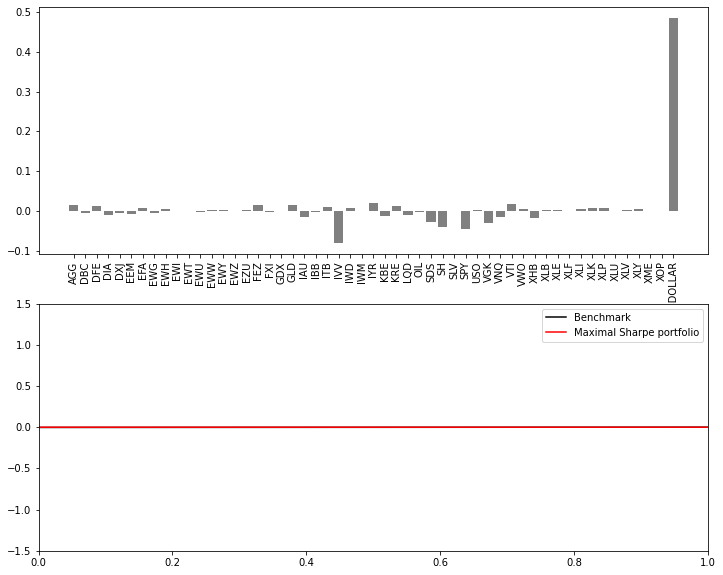

In [13]:
plot_results(result_equal, 
             result_maxsharpe, 
             actions_maxsharpe,  
             N_ASSETS,
             state.columns.tolist(), 
             'Maximal Sharpe portfolio', './images_etf/sharpe/', 'series')

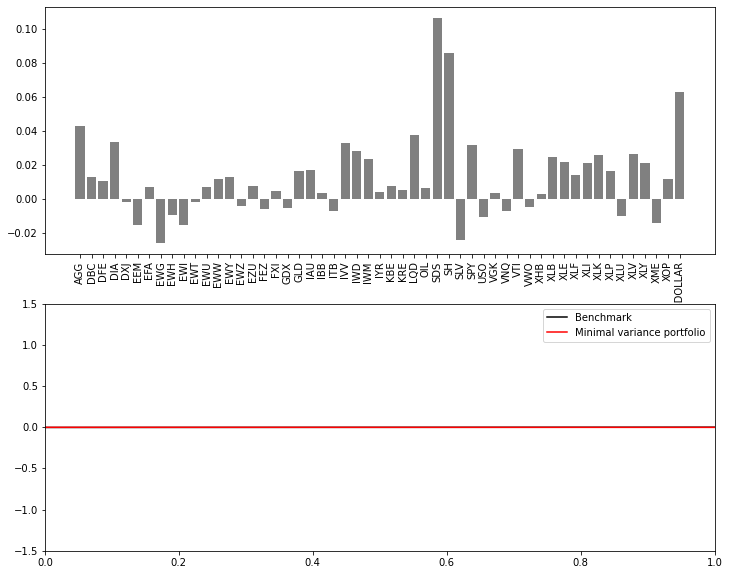

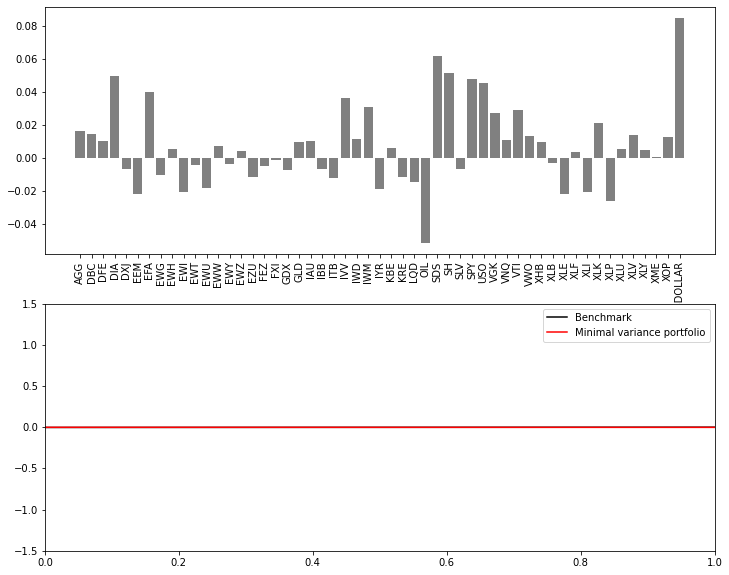

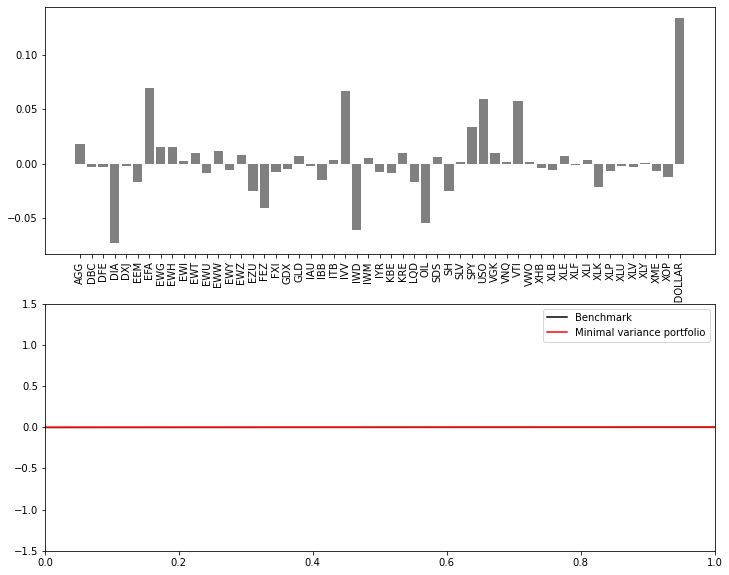

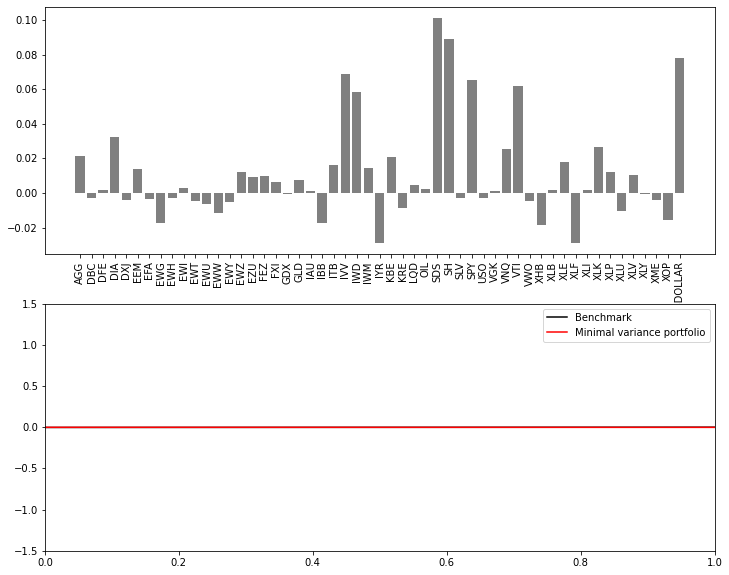

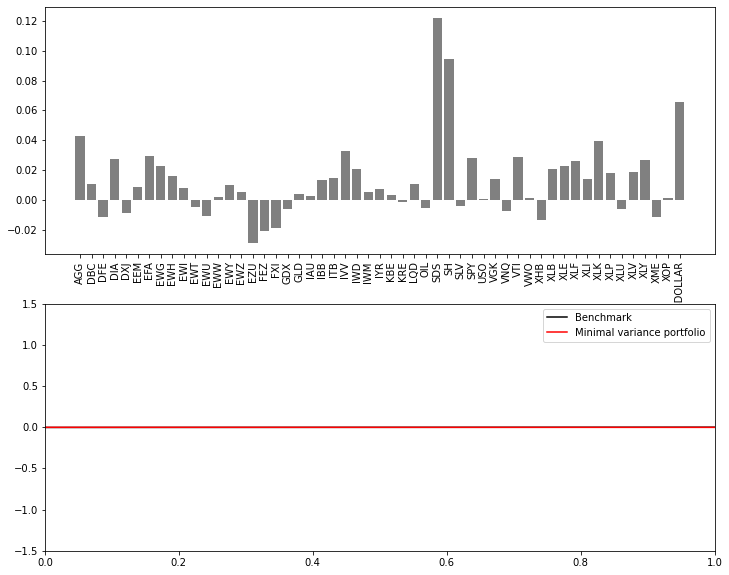

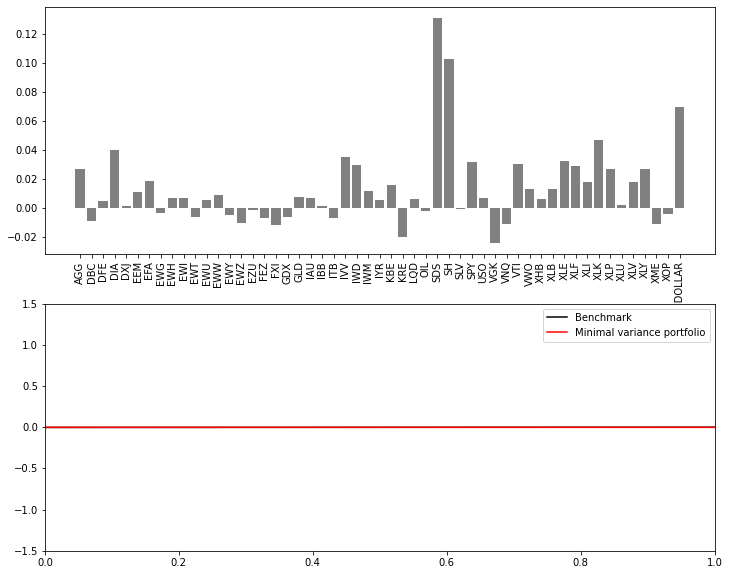

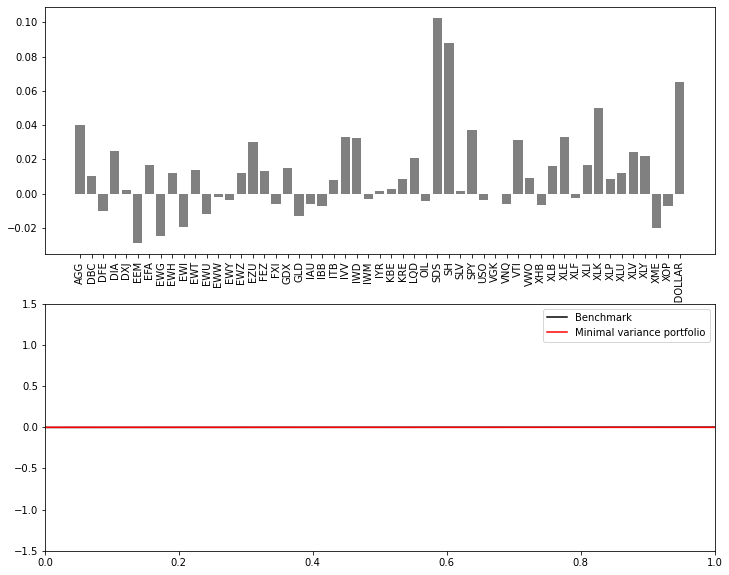

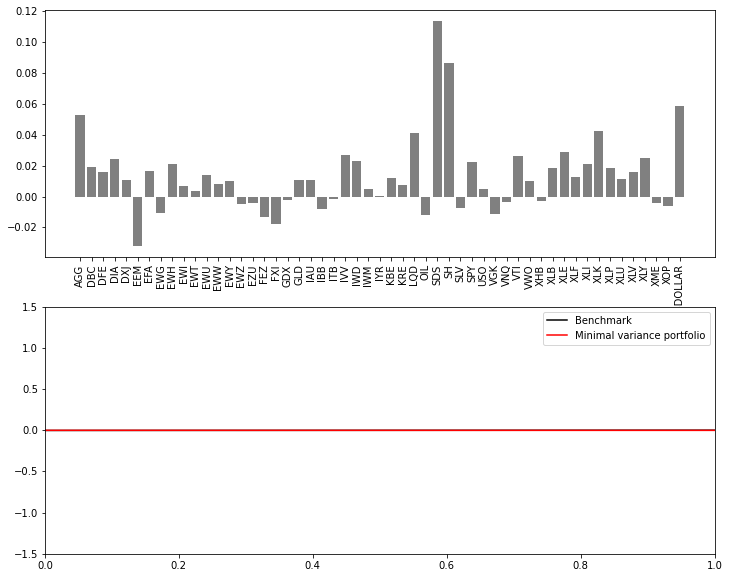

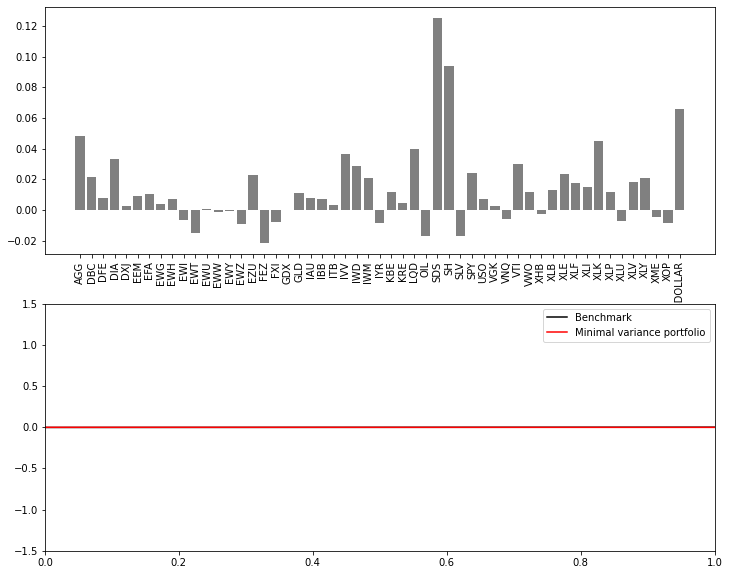

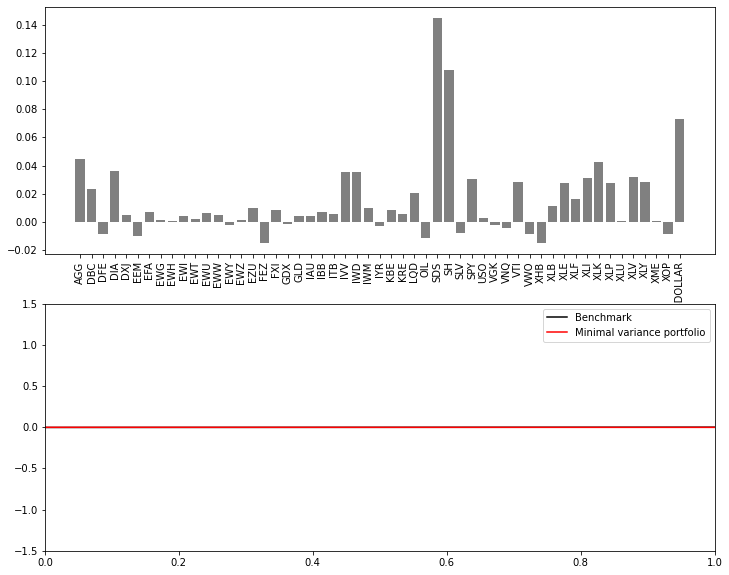

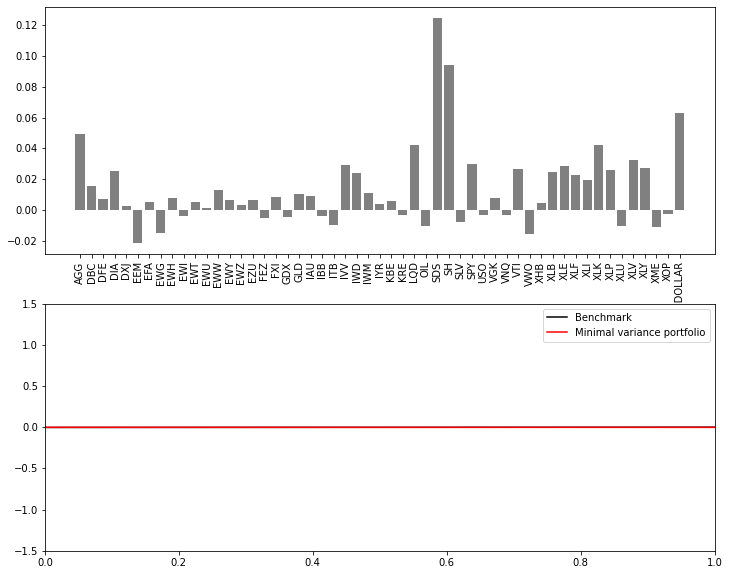

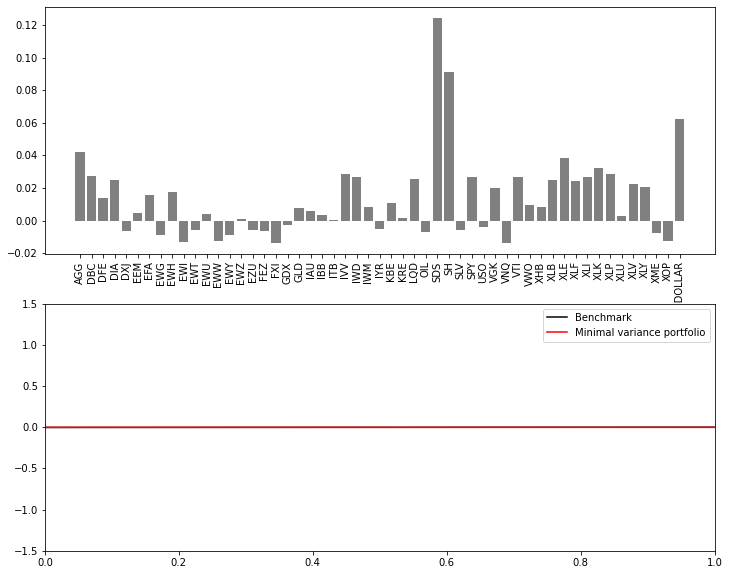

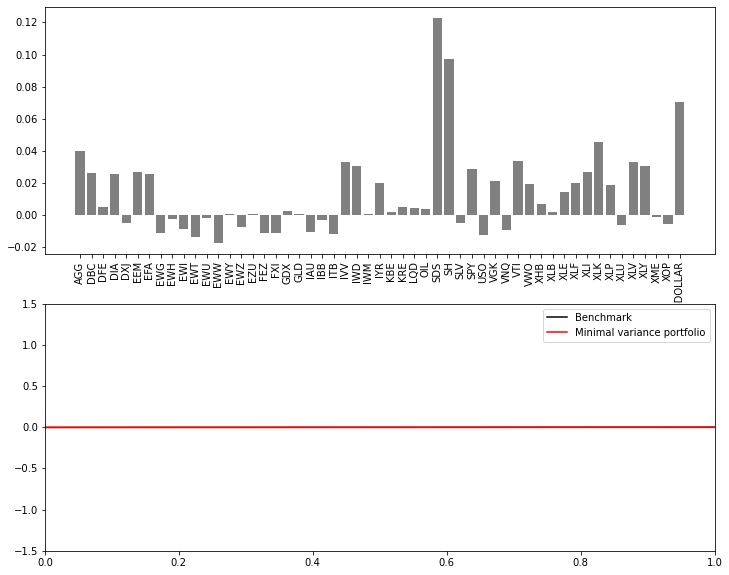

In [14]:
plot_results(result_equal, 
             result_minvar, 
             actions_minvar,  
             N_ASSETS,
             state.columns.tolist(), 
             'Minimal variance portfolio', './images_etf/minvar/', 'series')

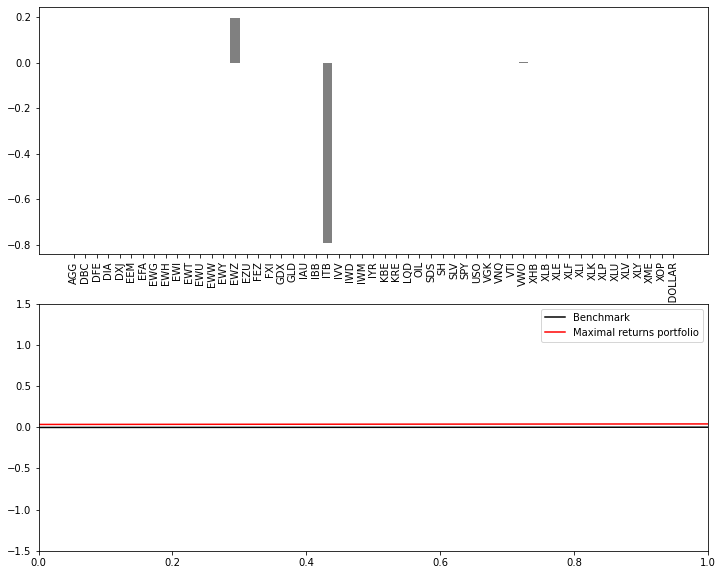

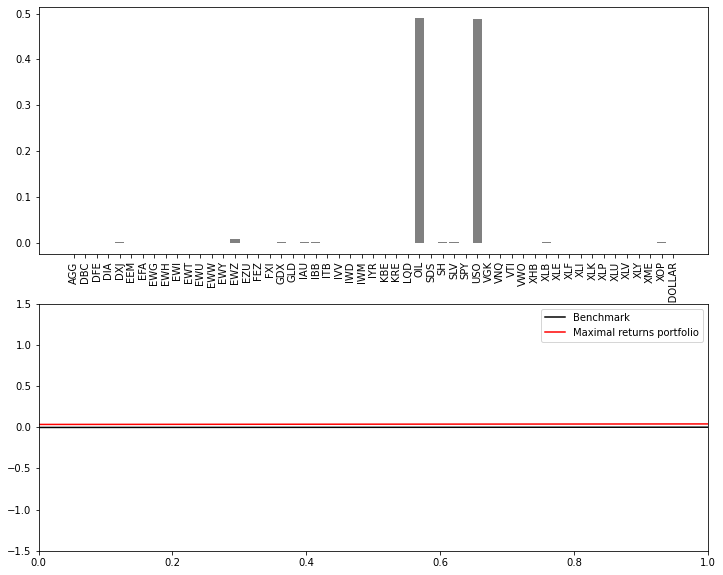

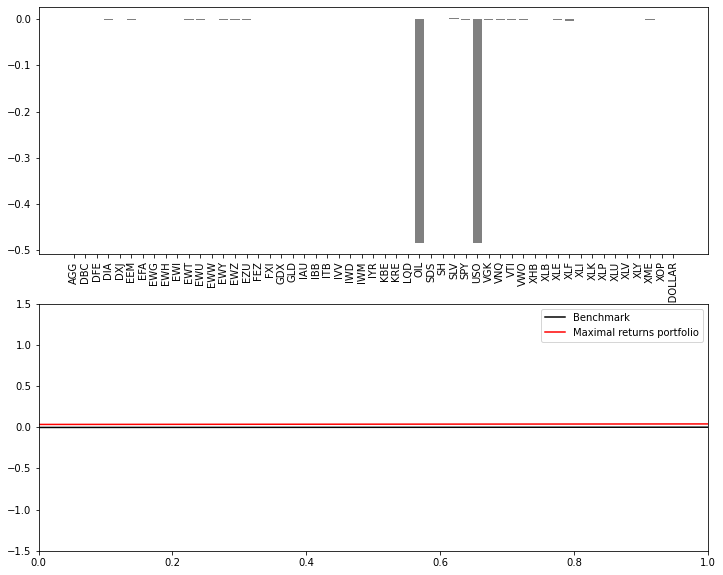

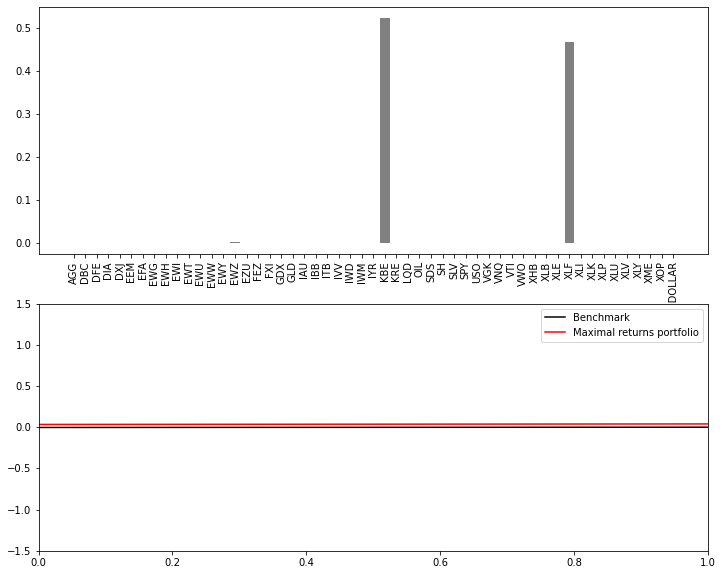

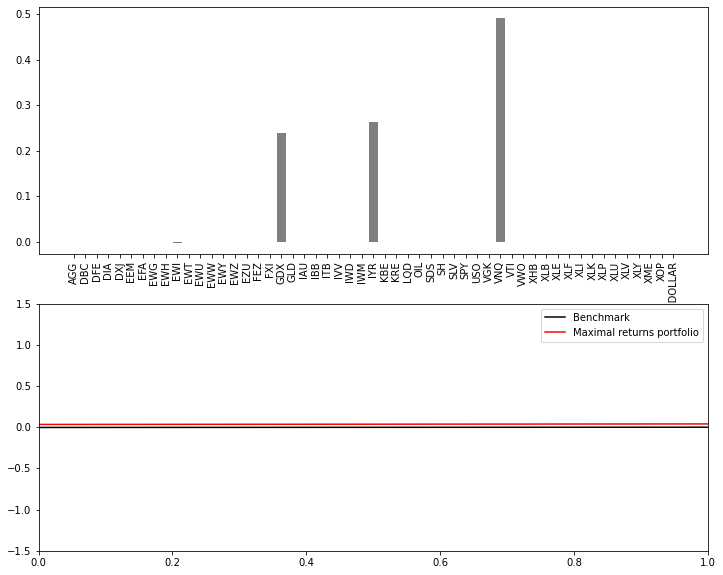

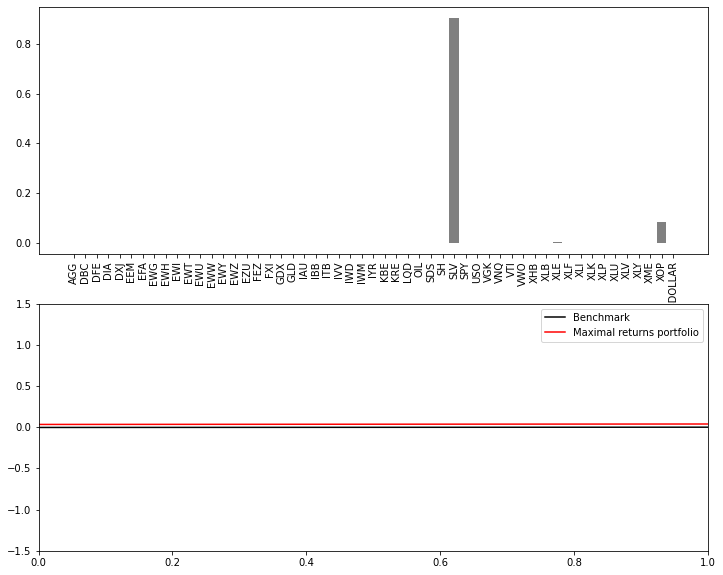

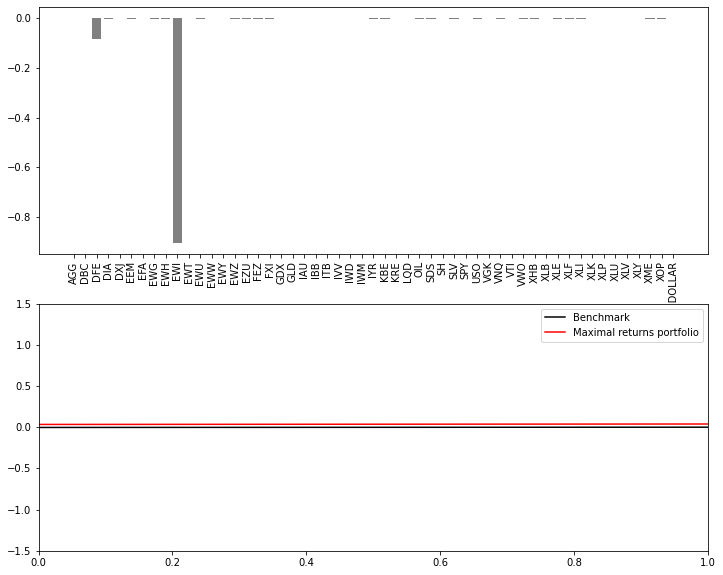

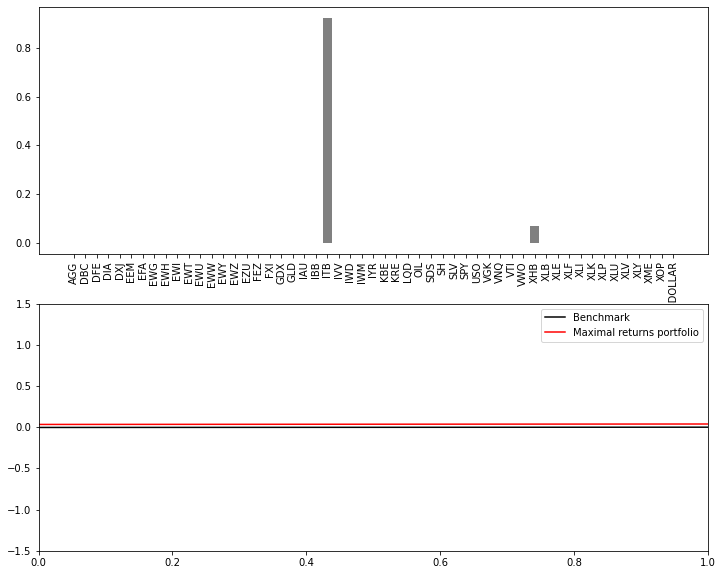

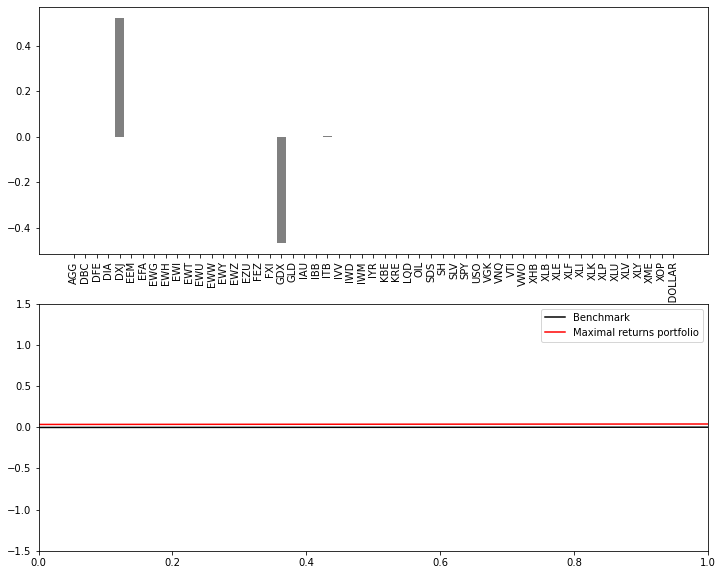

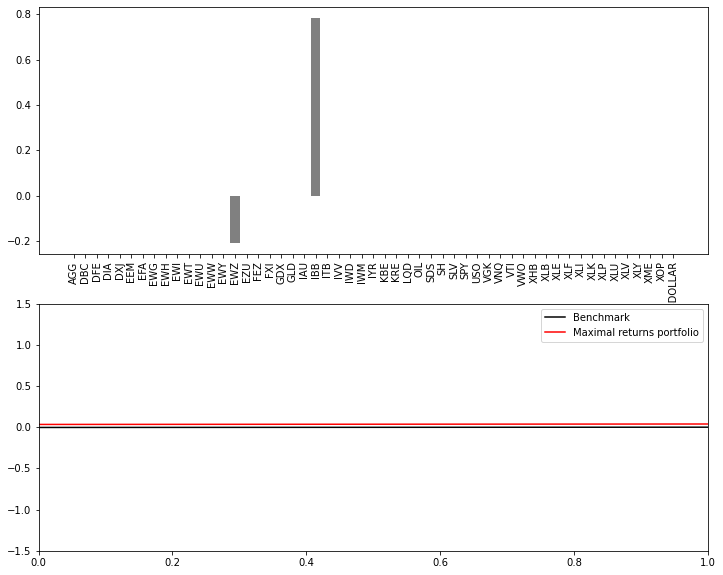

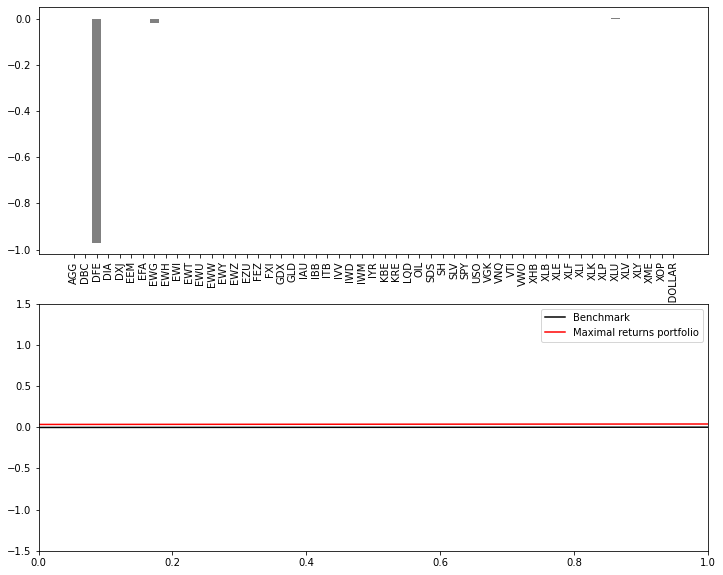

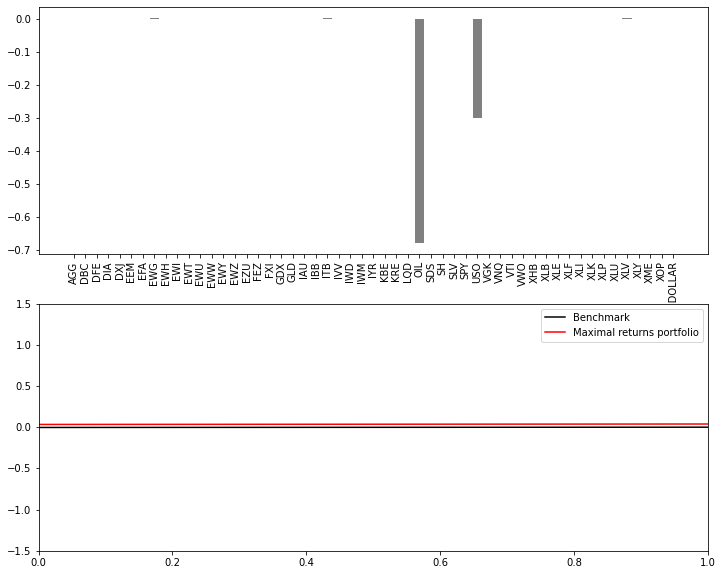

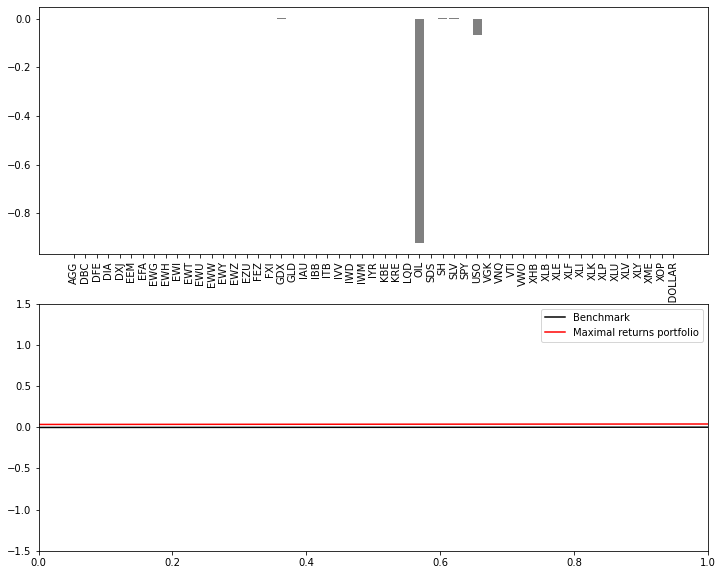

In [15]:
plot_results(result_equal, 
             result_returns, 
             actions_returns,  
             N_ASSETS,
             state.columns.tolist(), 
             'Maximal returns portfolio', './images_etf/maxret/', 'series')

# Reweighting process: PCA

In [16]:
from agent import PCAAgent

In [17]:
agent_pca = PCAAgent(N_ASSETS, allow_short=True, pc_id=0)

In [18]:
actions_equal, actions_pca = [], []
result_equal, result_pca = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False)
    
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_pca = agent_pca.act(state)
 
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_pca)
    result_pca.append(r.tolist())
    actions_pca.append(action_pca)

# Evaluation

In [19]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_pca_vis = [item for sublist in result_pca for item in sublist]

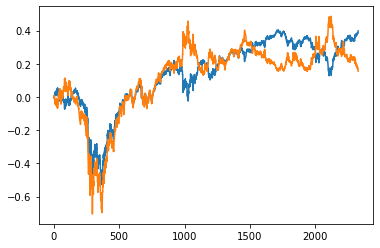

In [20]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum())
plt.plot(np.array(result_pca_vis).cumsum())
plt.show()

In [21]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('PCA', print_stats(result_pca_vis, result_equal_vis))

EQUAL [0.0002, 0.0124, 0.2207, 0.0, 1.0]
PCA [0.0001, 0.0163, 0.0627, 0.0, 0.3522]


# Visualization

In [22]:
import matplotlib
current_cmap = matplotlib.cm.get_cmap()

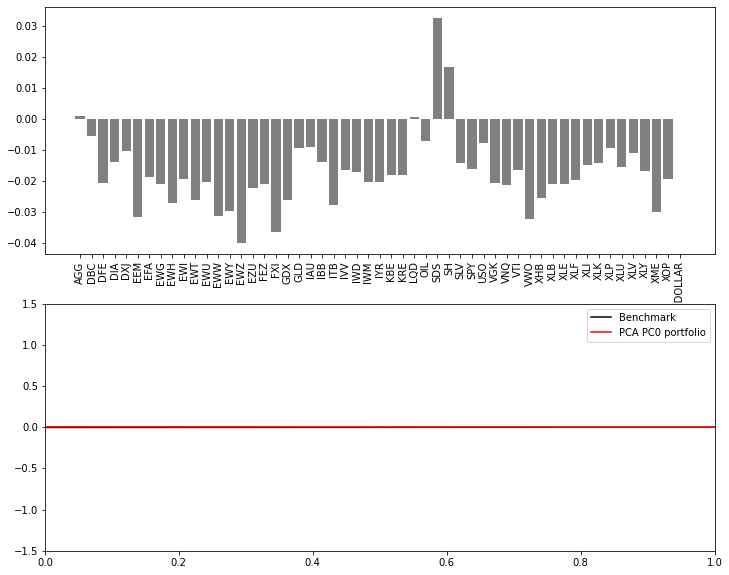

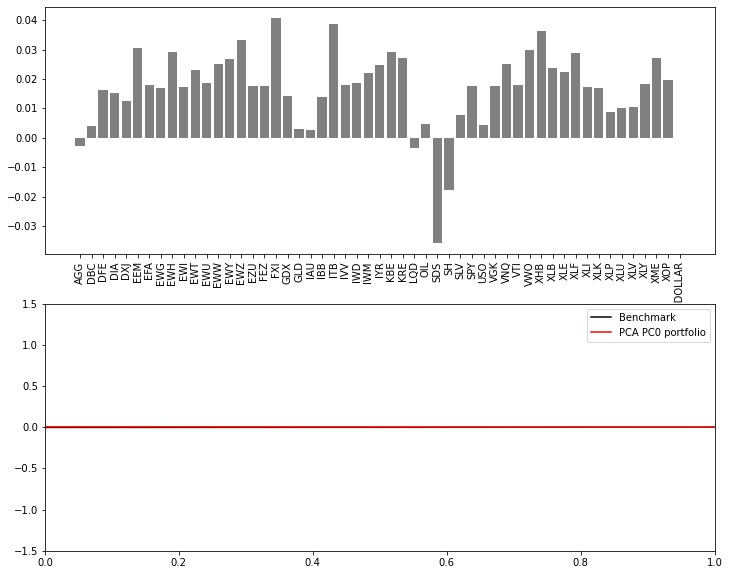

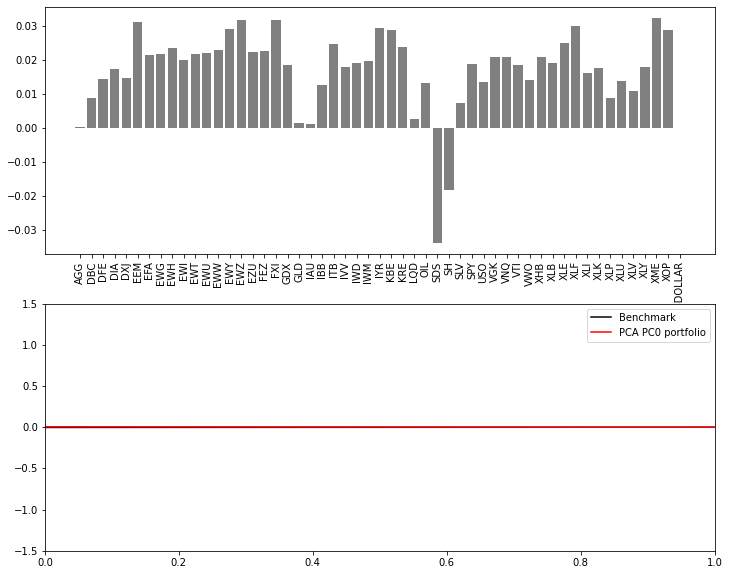

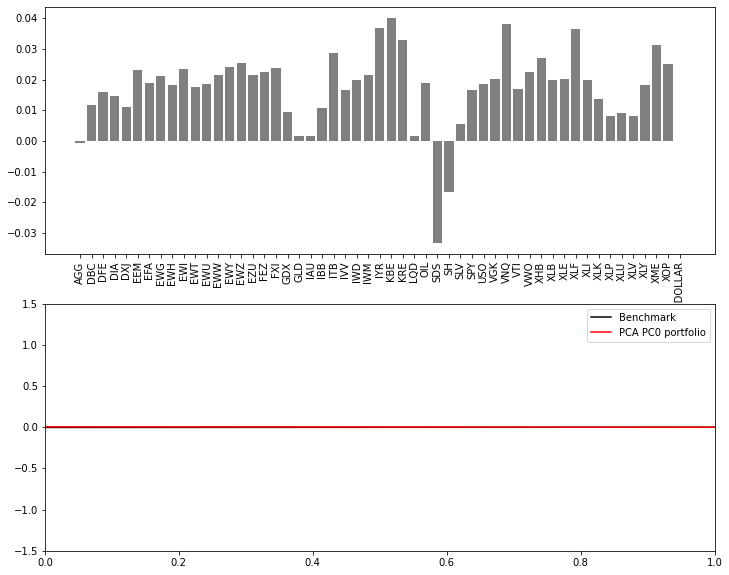

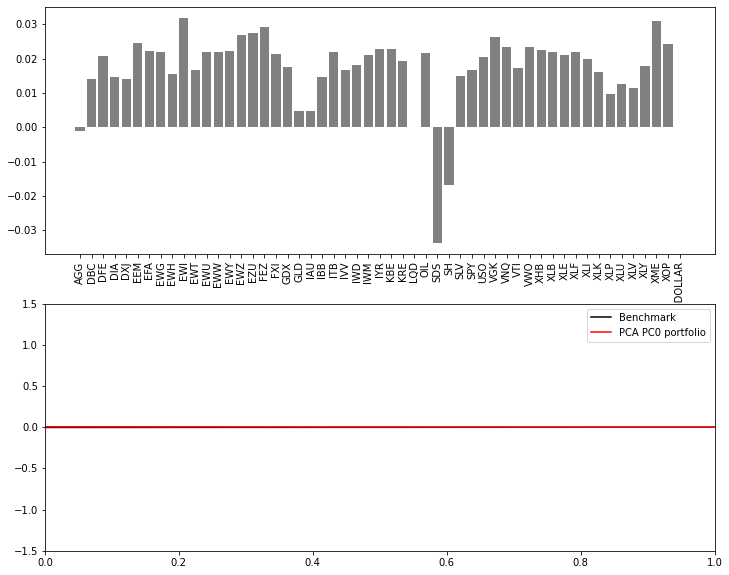

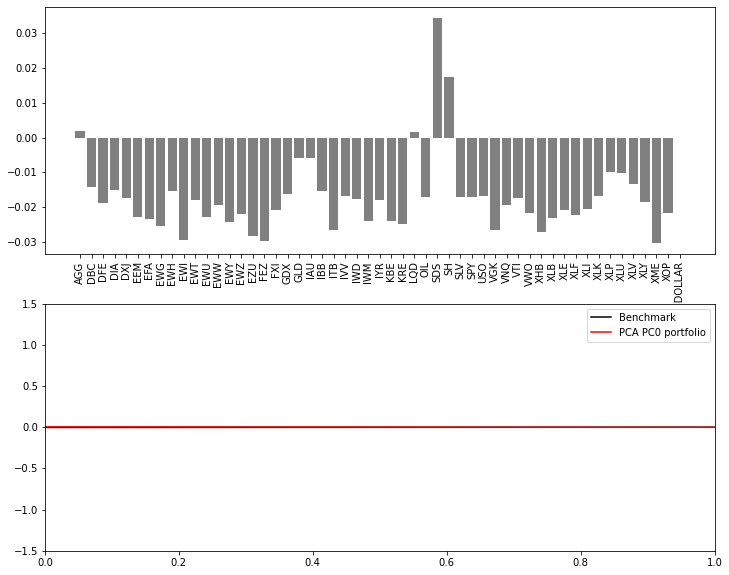

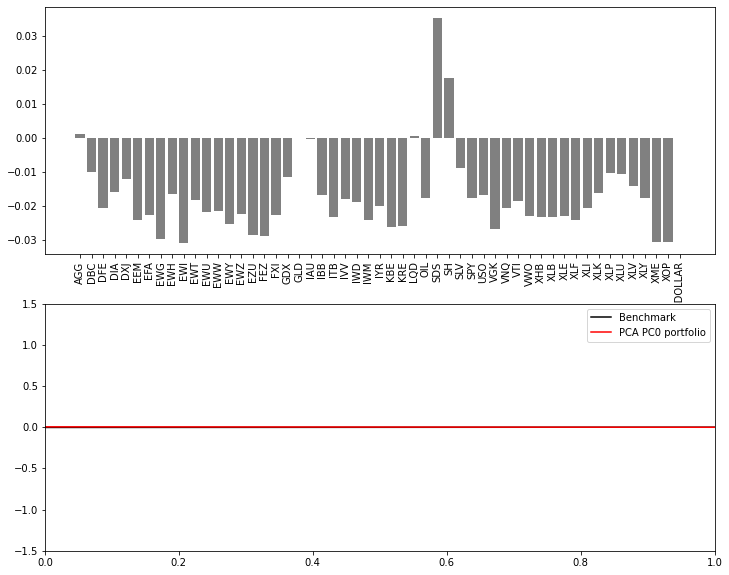

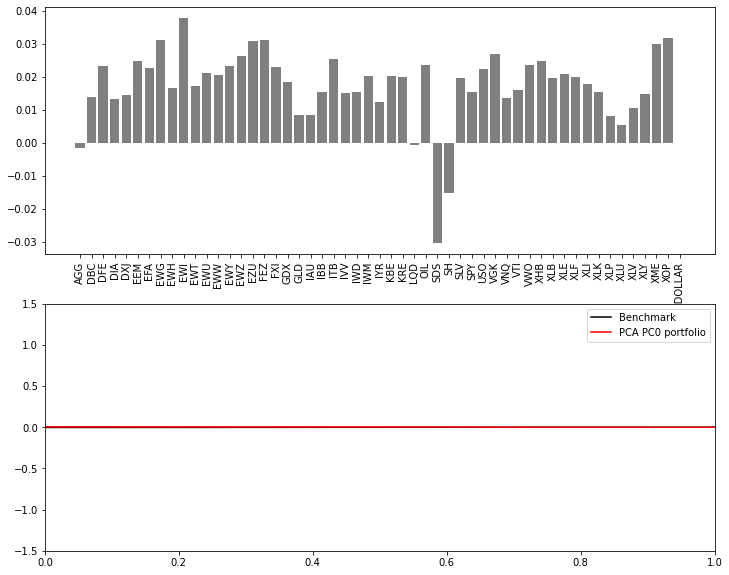

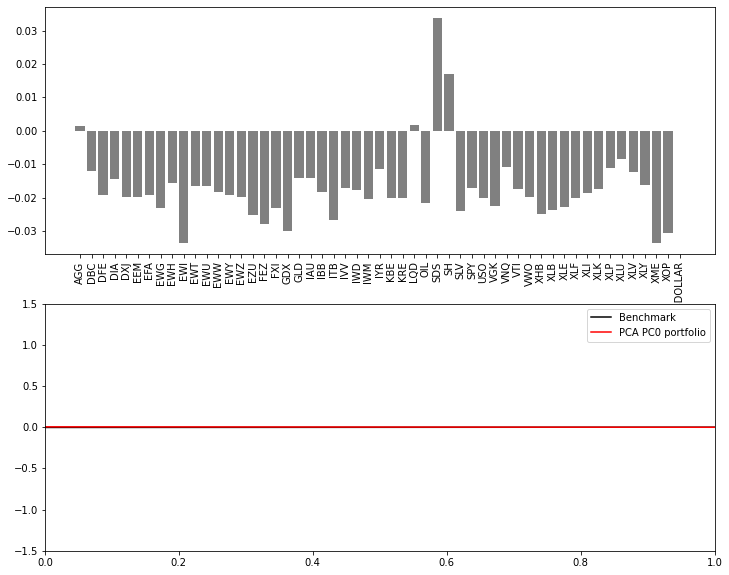

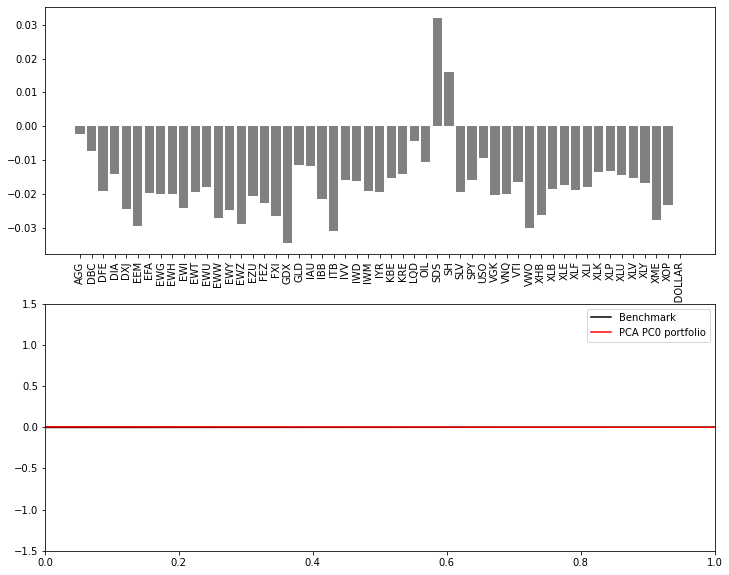

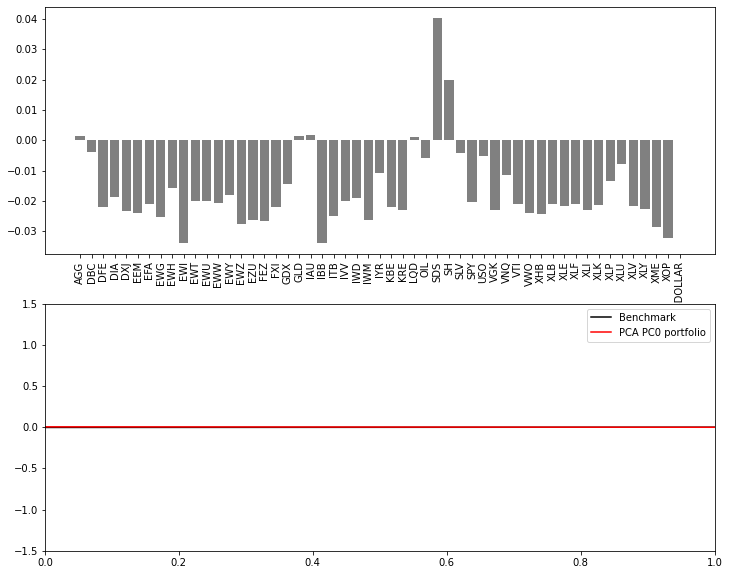

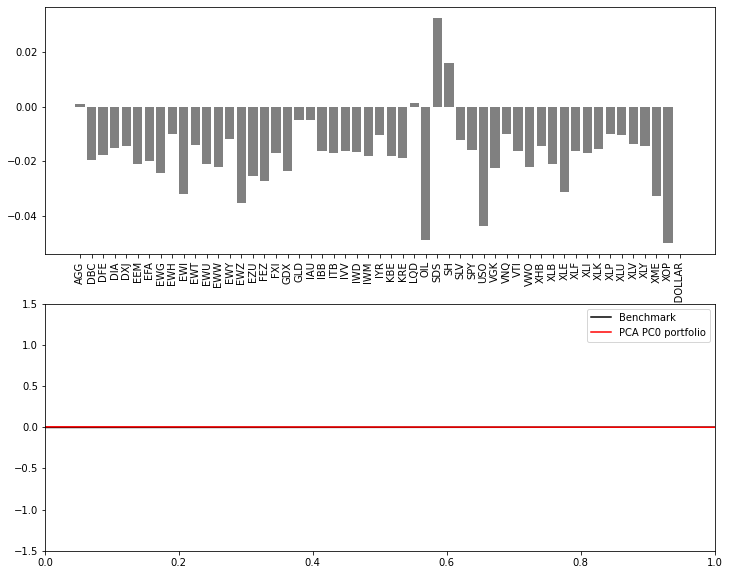

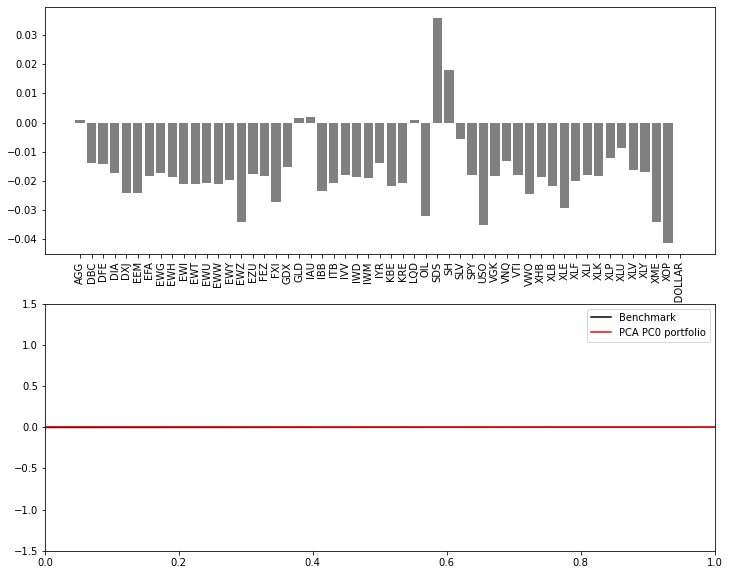

In [23]:
plot_results(result_equal, 
             result_pca, 
             actions_pca, 
             N_ASSETS,
             state.columns, 
             'PCA PC0 portfolio', './images_etf/pca/', 'series')

# Reweighting process: HRP

In [24]:
from agent import HRPAgent

In [25]:
agent_hrp = HRPAgent(N_ASSETS, allow_short=True)

In [26]:
actions_equal, actions_hrp = [], []
result_equal, result_hrp = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False)
    
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_hrp = agent_hrp.act(state)

    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_hrp)
    result_hrp.append(r.tolist())
    actions_hrp.append(action_hrp)

In [27]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_hrp_vis = [item for sublist in result_hrp for item in sublist]

# Evaluation

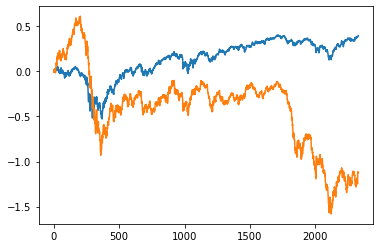

In [28]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum())
plt.plot(np.array(result_hrp_vis).cumsum())
plt.show()

In [29]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('HRP', print_stats(result_hrp_vis, result_equal_vis))

EQUAL [0.0002, 0.0124, 0.2207, 0.0, 1.0]
HRP [-0.0005, 0.0227, -0.344, -0.0007, 1.0547]


# Visualization

In [30]:
import matplotlib
current_cmap = matplotlib.cm.get_cmap()

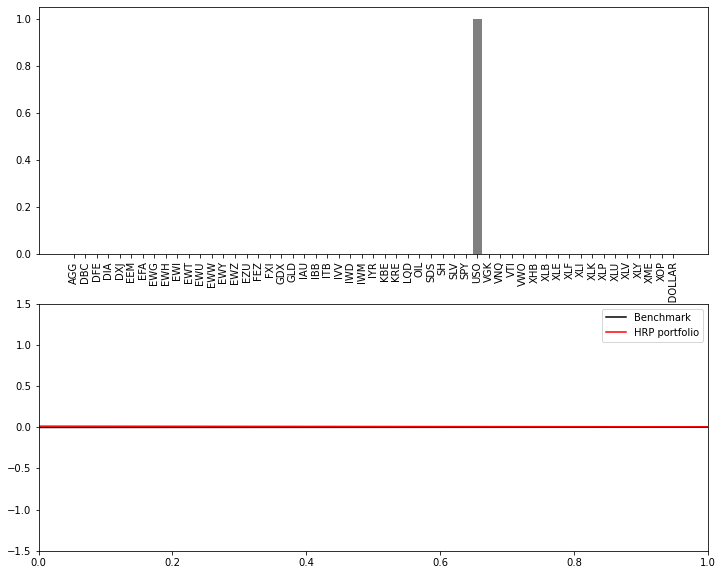

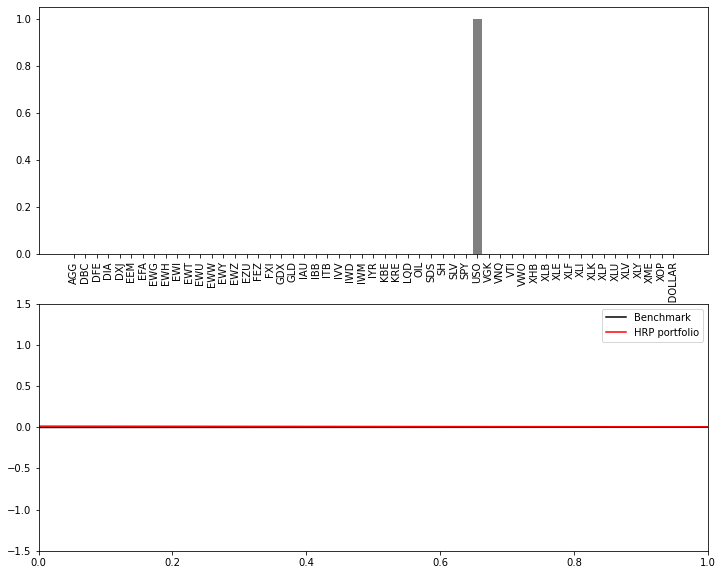

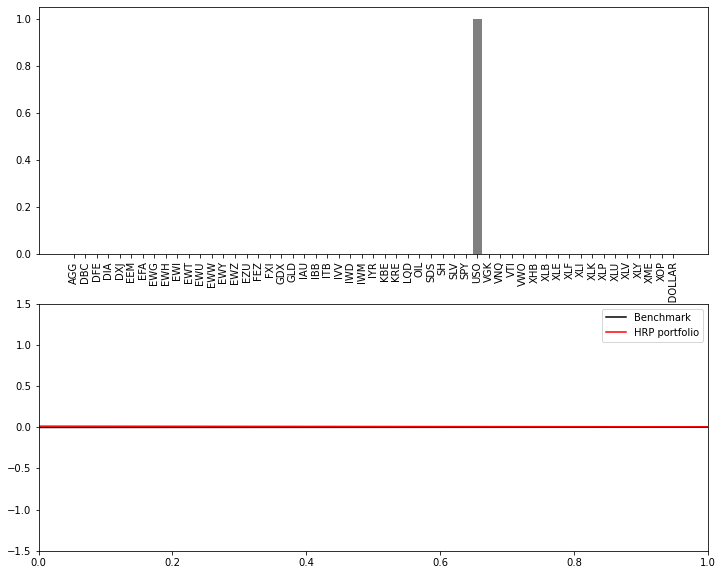

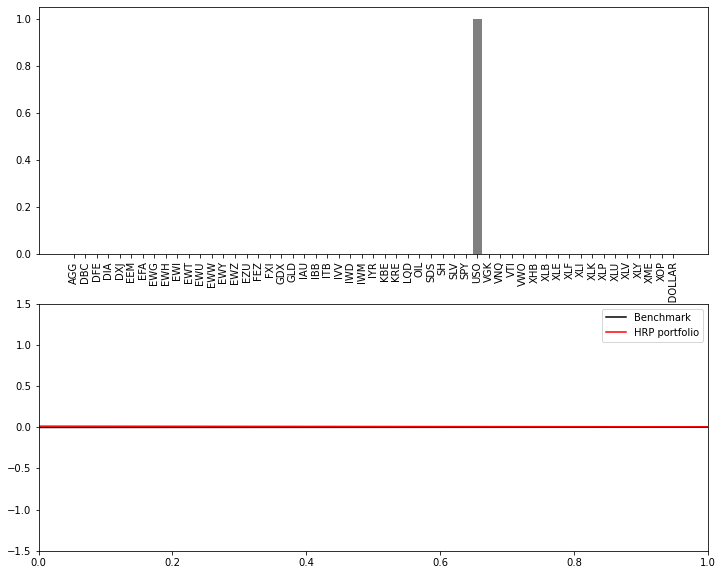

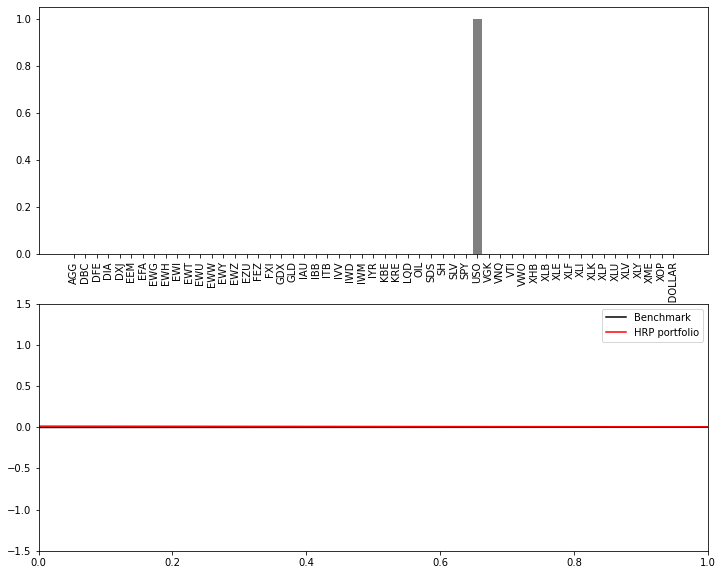

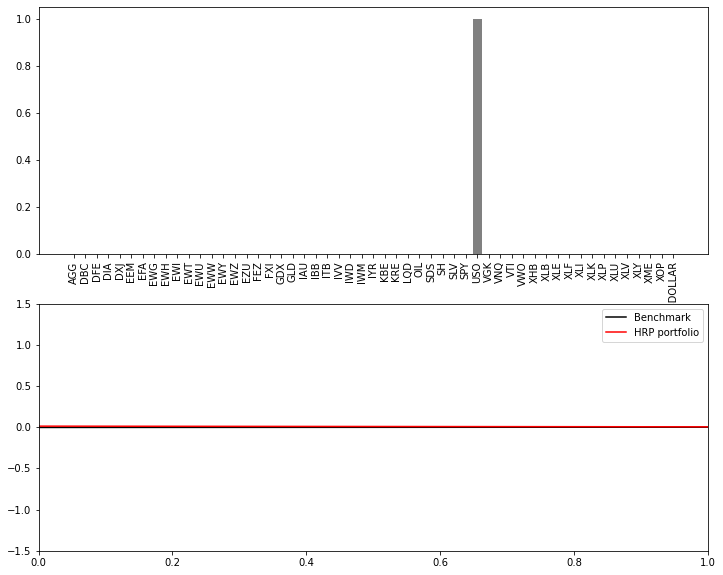

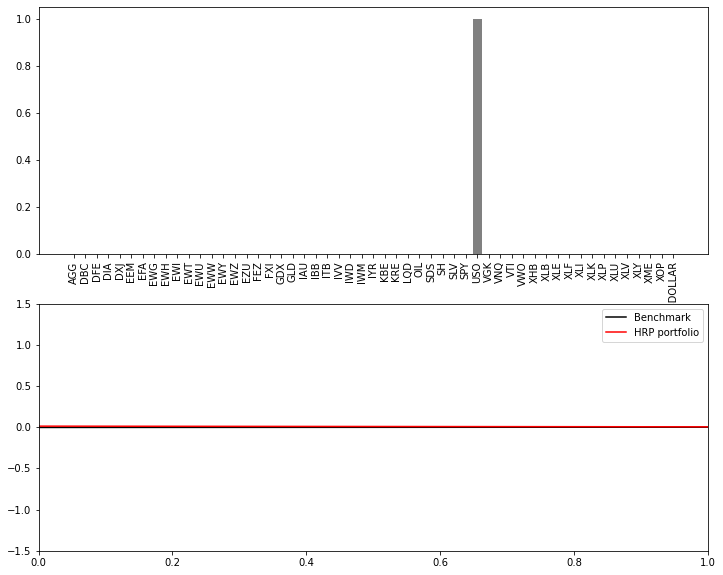

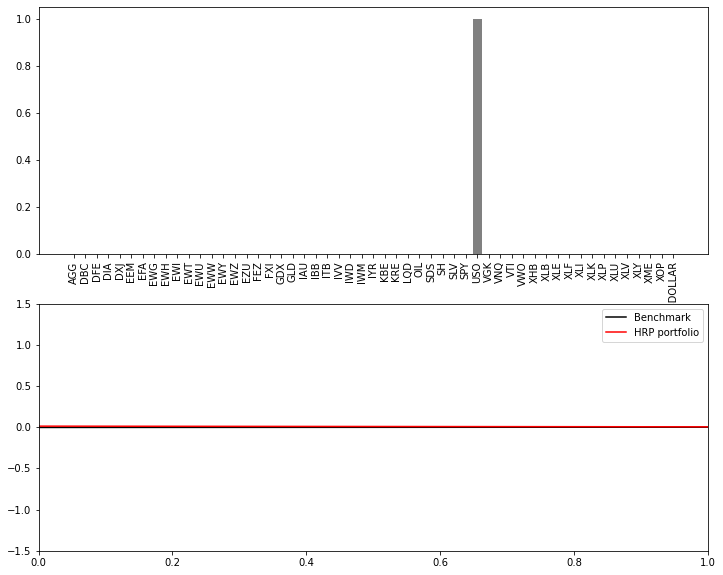

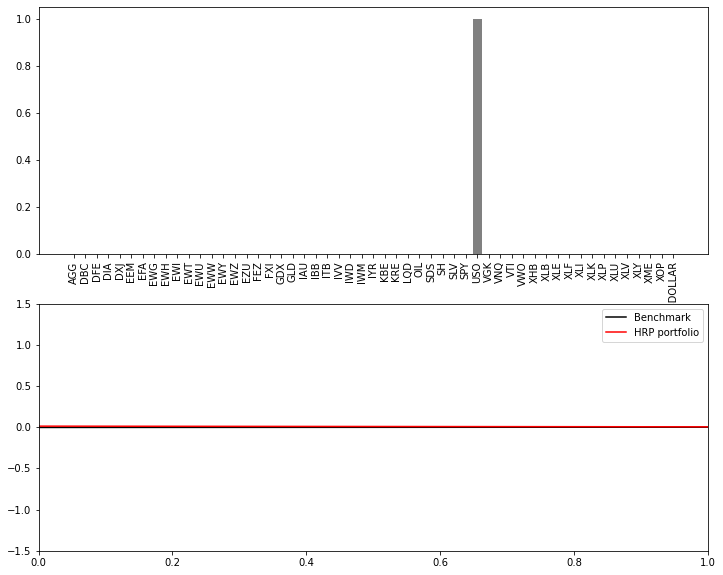

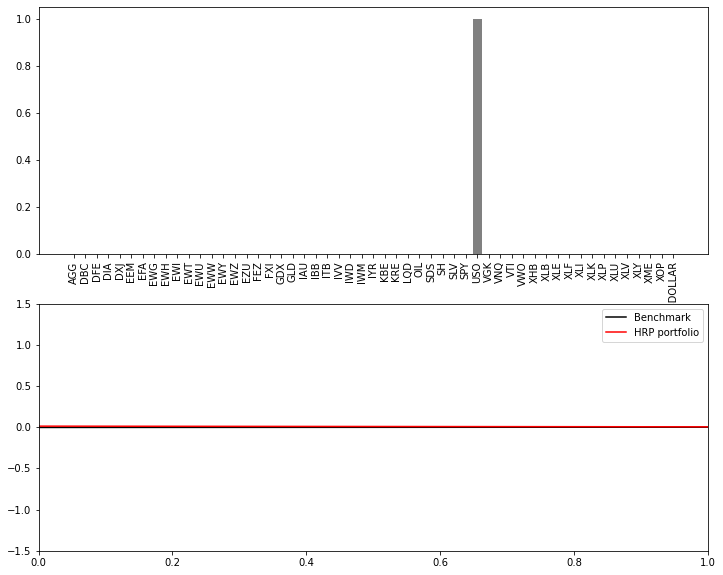

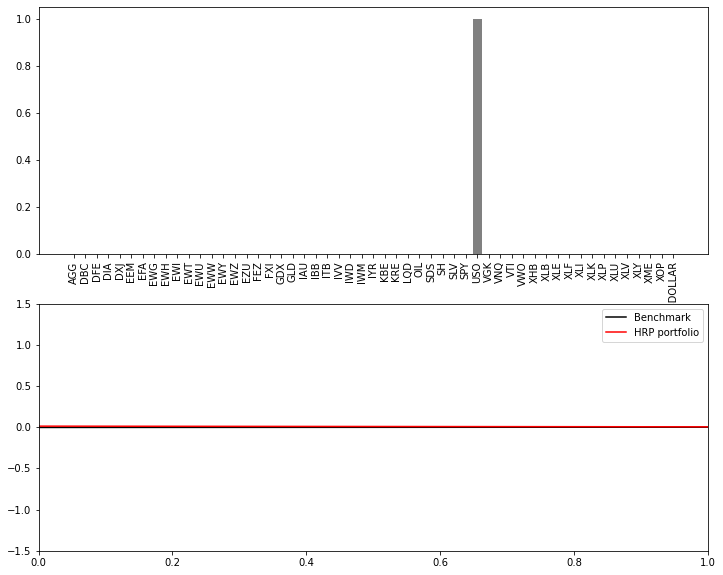

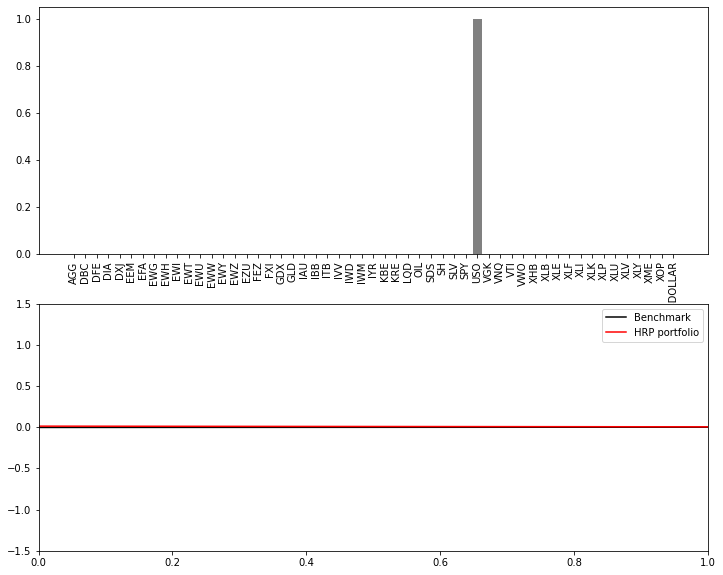

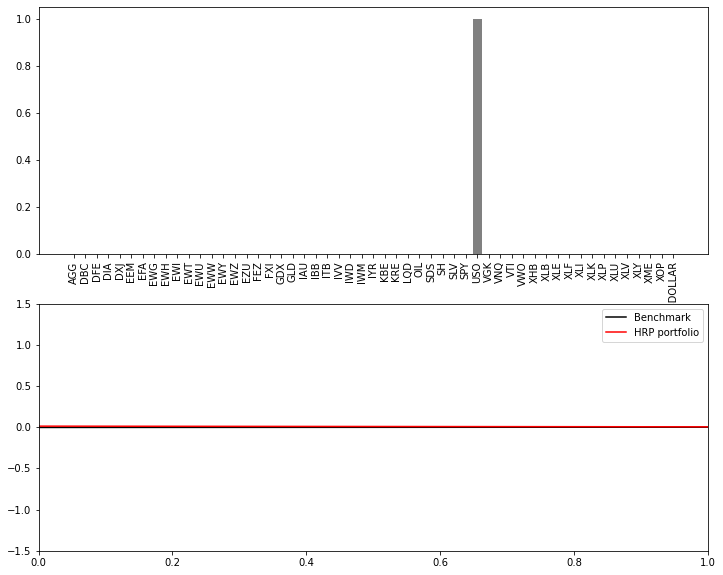

In [31]:
plot_results(result_equal, 
             result_hrp, 
             actions_hrp, 
             N_ASSETS,
             state.columns, 
             'HRP portfolio', './images_etf/hrp/', 'series')

# Reweighting process: Forecasting 

In [32]:
from agent import SmoothingAgent

In [33]:
agent_smooth = SmoothingAgent(N_ASSETS, allow_short=True, forecast_horizon = WINDOW_HOLD)

In [34]:
actions_equal, actions_smooth = [], []
result_equal, result_smooth = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False, is_raw_time_series=True)
    
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_smooth = agent_smooth.act(state)

    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_smooth)
    result_smooth.append(r.tolist())
    actions_smooth.append(action_smooth)

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/bas

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/bas

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Roy/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index

In [35]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_smooth_vis = [item for sublist in result_smooth for item in sublist]

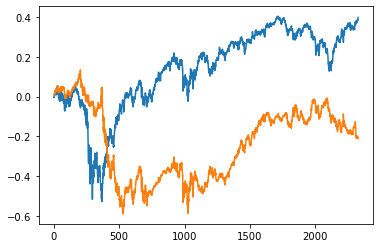

In [36]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum())
plt.plot(np.array(result_smooth_vis).cumsum())
plt.show()

In [37]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('SMOOTHING', print_stats(result_smooth_vis, result_equal_vis))

EQUAL [0.0002, 0.0124, 0.2207, 0.0, 1.0]
SMOOTHING [-0.0001, 0.0113, -0.1295, -0.0001, 0.0621]


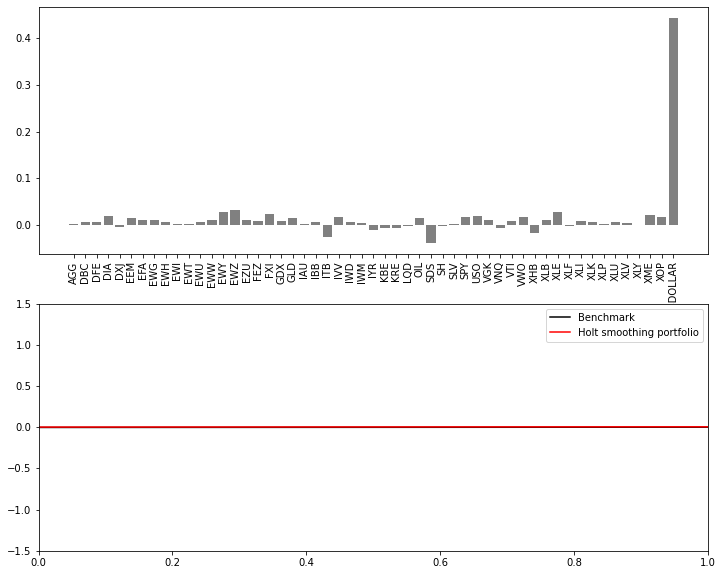

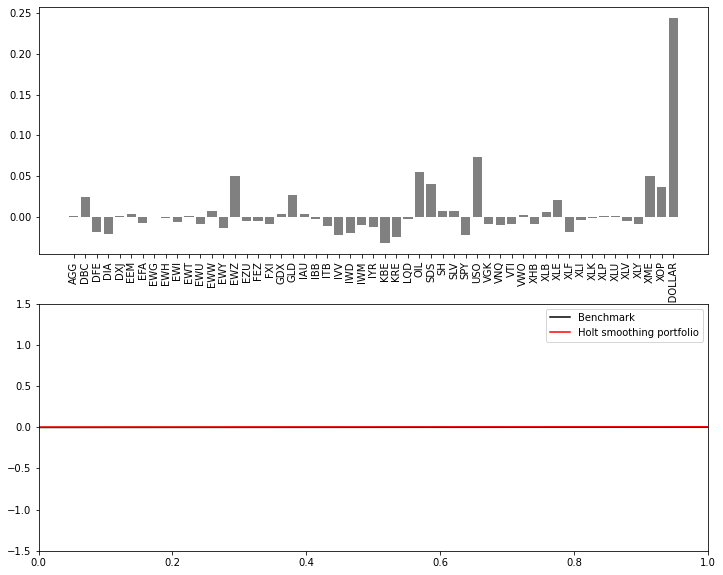

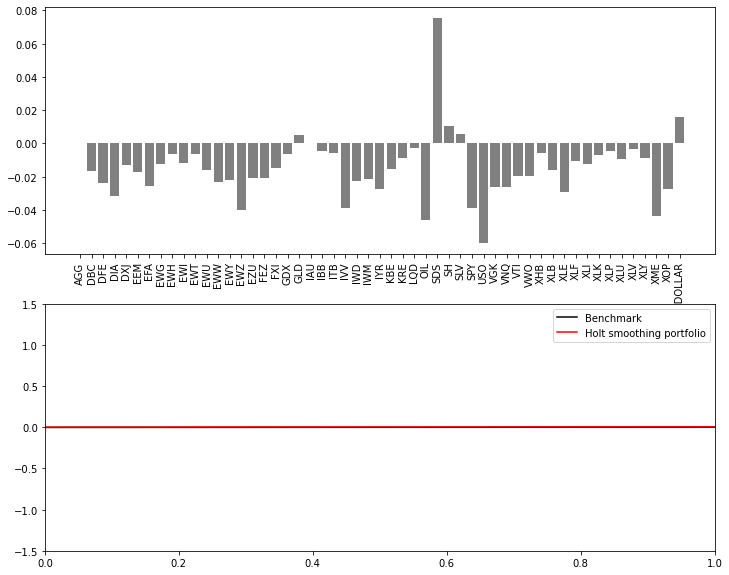

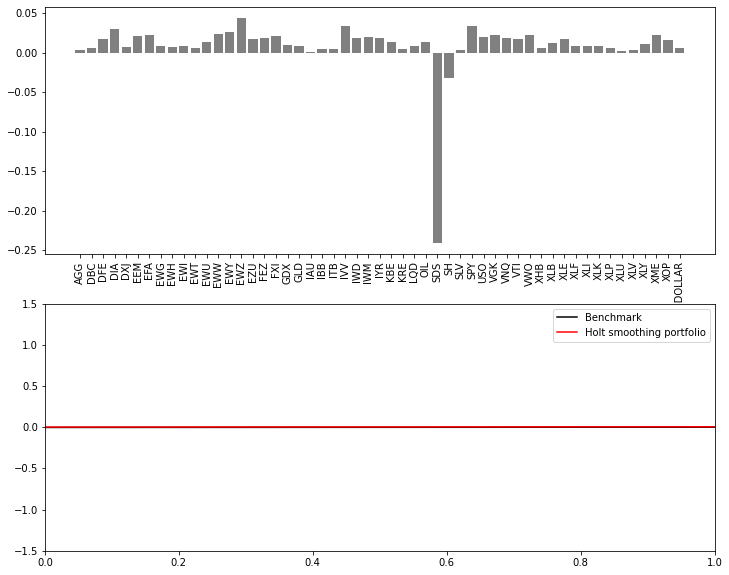

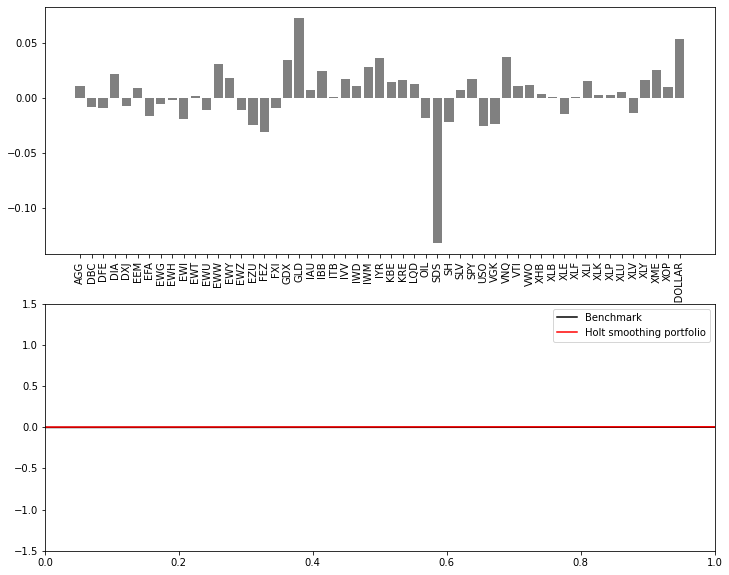

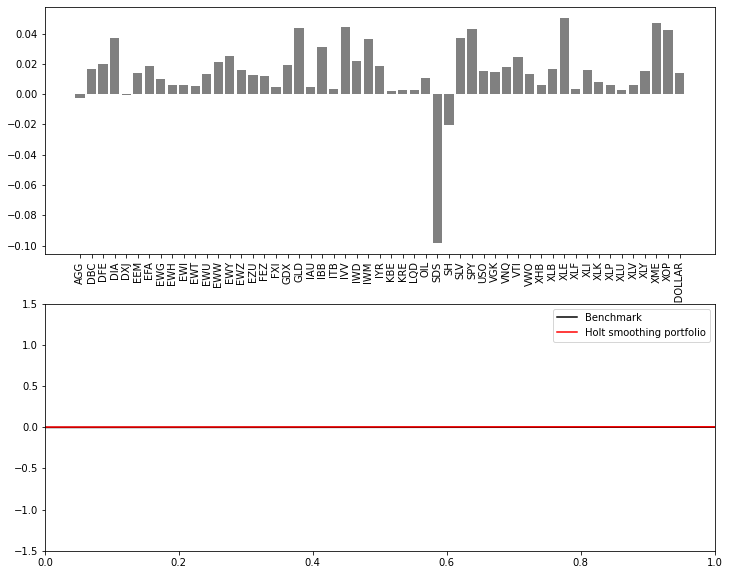

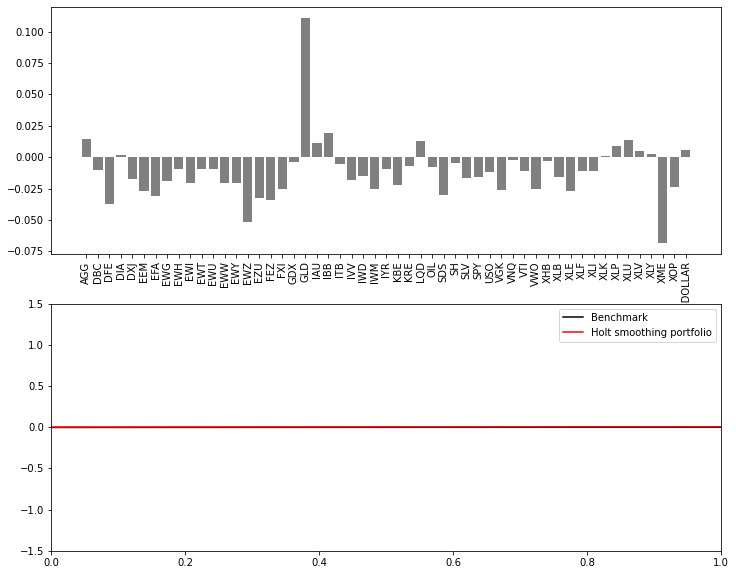

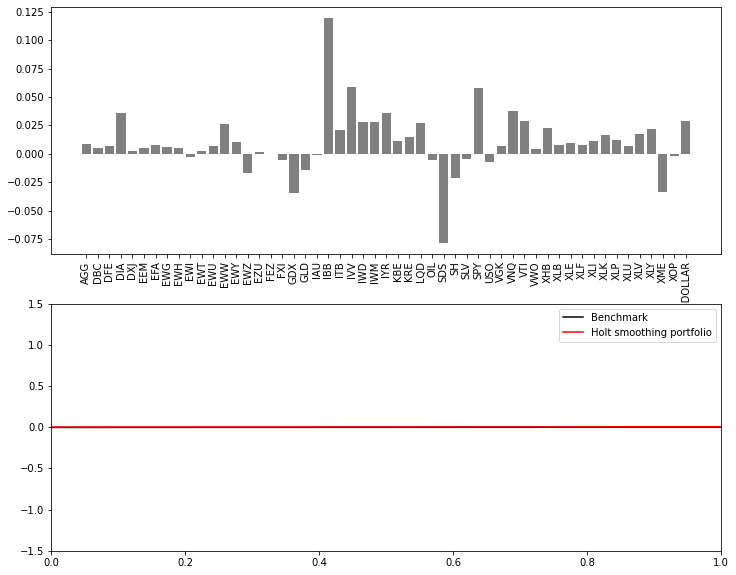

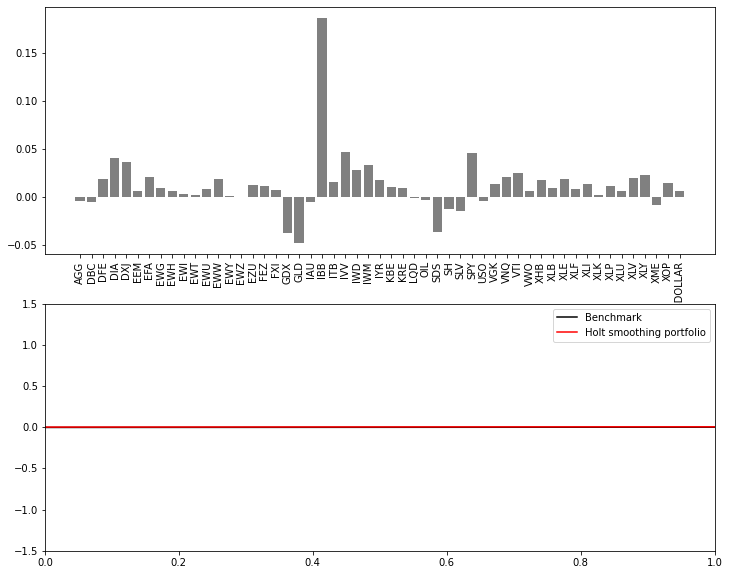

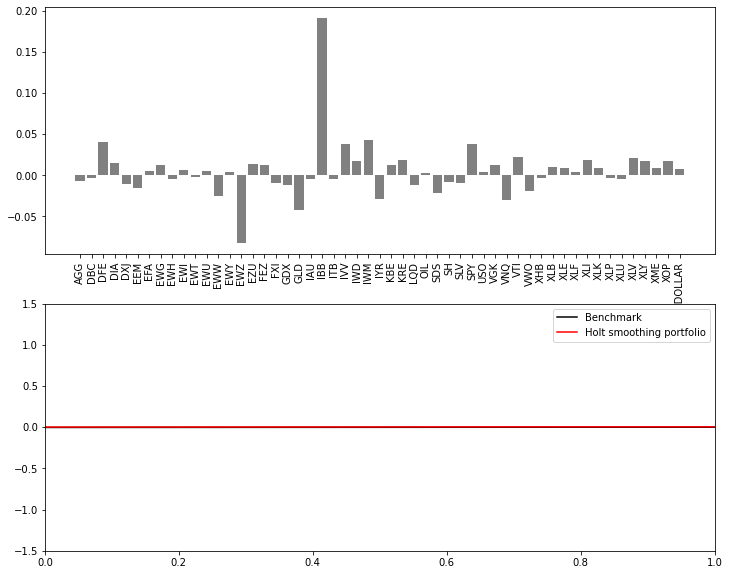

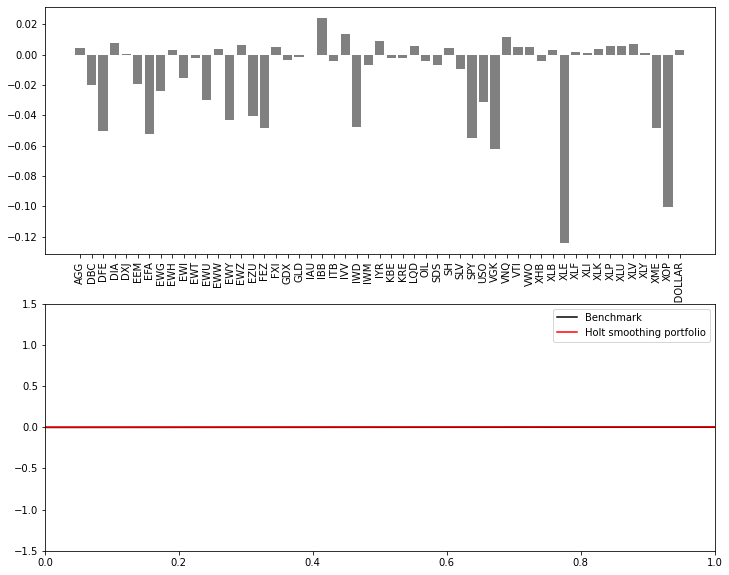

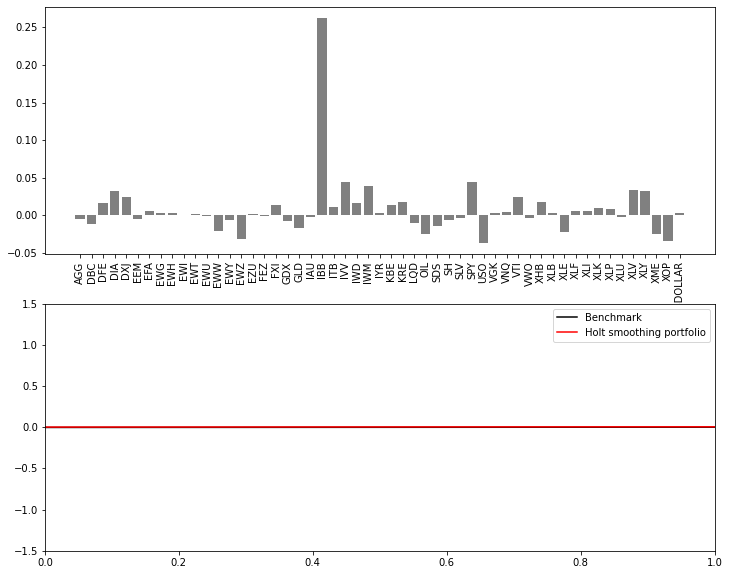

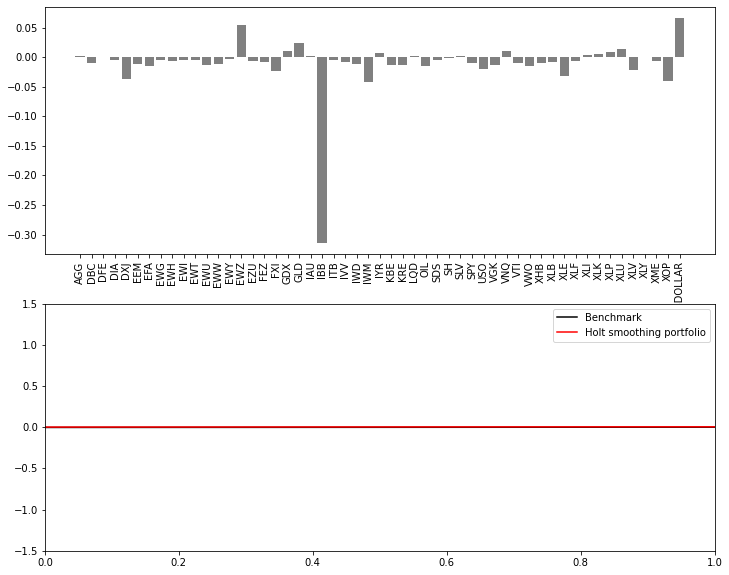

In [38]:
plot_results(result_equal, 
             result_smooth, 
             actions_smooth,
             N_ASSETS,
             state.columns, 
             'Holt smoothing portfolio', './images_etf/smoothing/', 'series')

# Reweighting process: Autoencoder

In [39]:
from agent import AutoencoderAgent

In [40]:
agent_ae = AutoencoderAgent(N_ASSETS, allow_short=True, encoding_dim = 5)

In [41]:
actions_equal, actions_ae = [], []
result_equal, result_ae = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False, is_raw_time_series=True)
    
    action_equal = np.ones(N_ASSETS) / N_ASSETS
    action_ae = agent_ae.act(state)

    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal)
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_ae)
    result_ae.append(r.tolist())
    actions_ae.append(action_ae)

In [42]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_ae_vis = [item for sublist in result_ae for item in sublist]

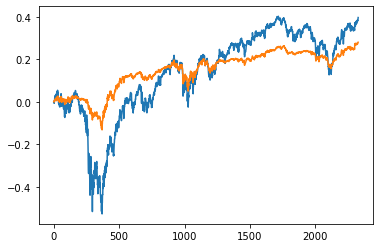

In [43]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum())
plt.plot(np.array(result_ae_vis).cumsum())
plt.show()

In [44]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('AUTOENCODER', print_stats(result_ae_vis, result_equal_vis))

EQUAL [0.0002, 0.0124, 0.2207, 0.0, 1.0]
AUTOENCODER [0.0001, 0.0047, 0.4028, 0.0001, 0.3469]


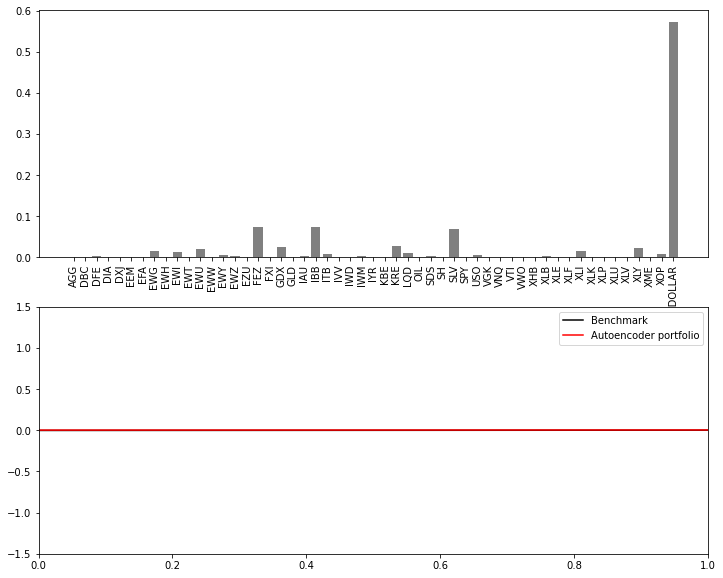

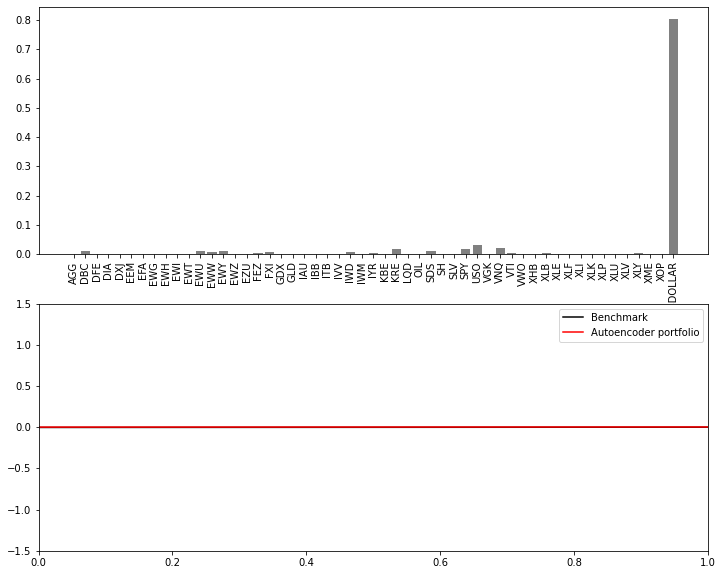

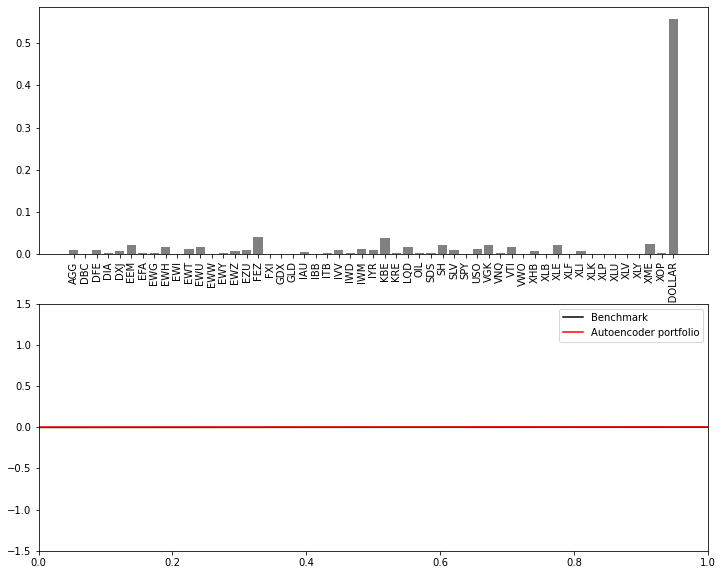

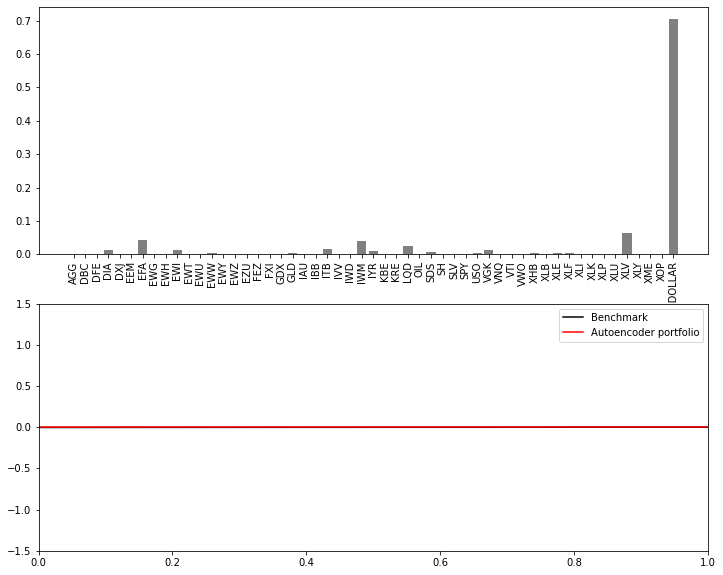

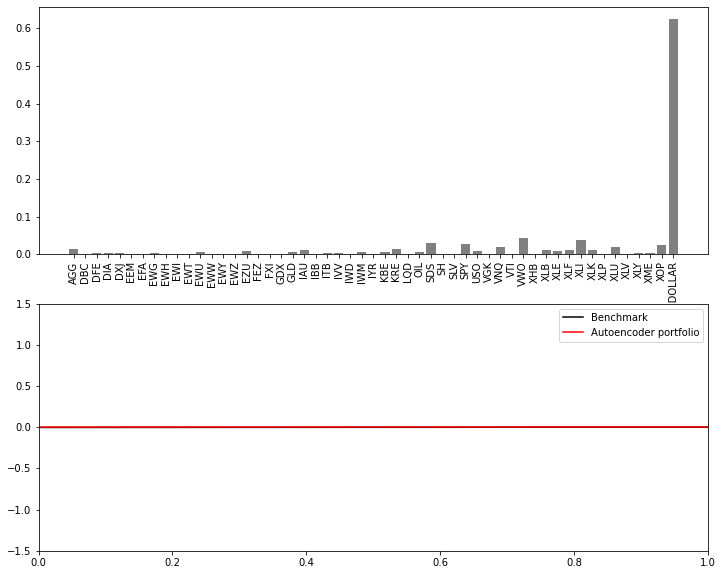

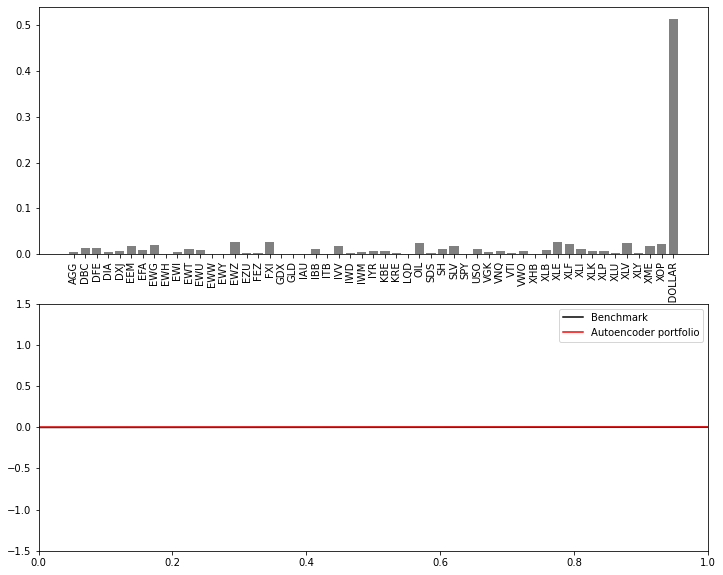

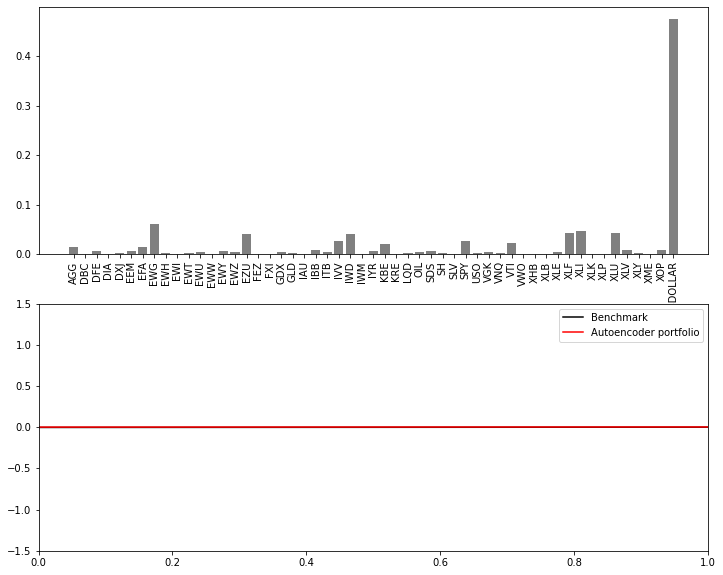

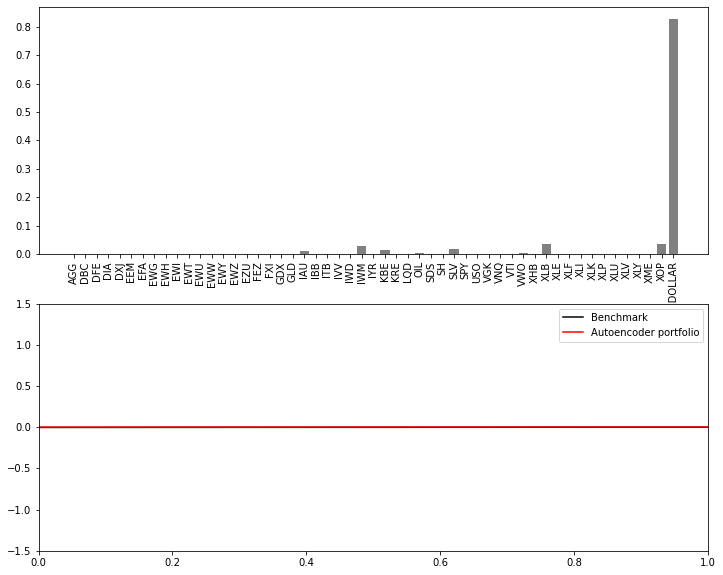

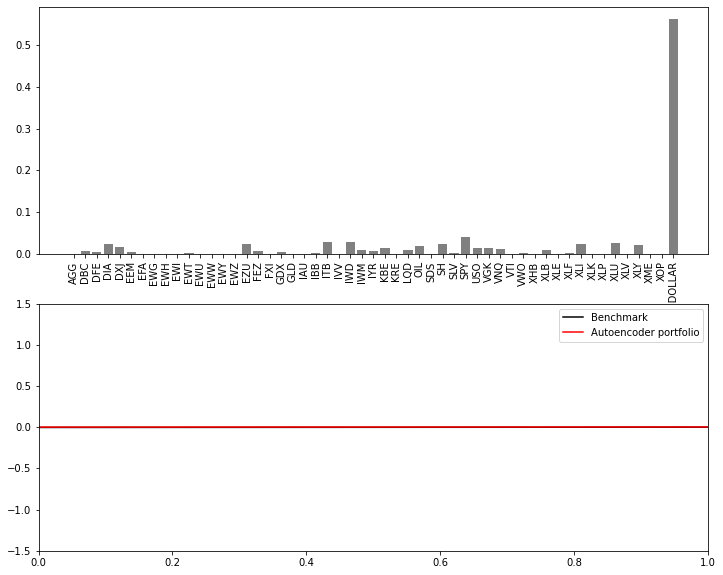

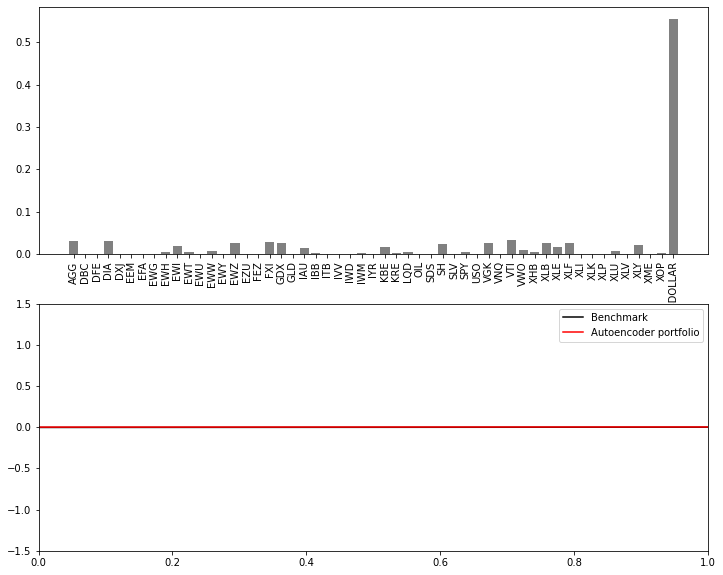

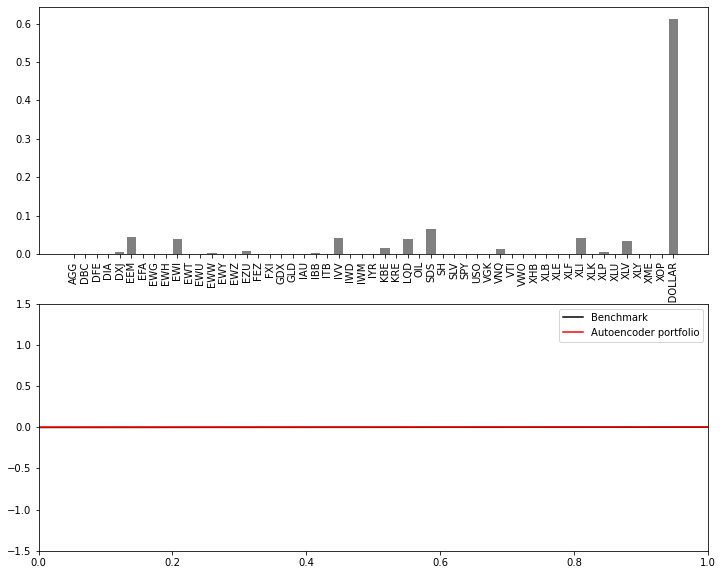

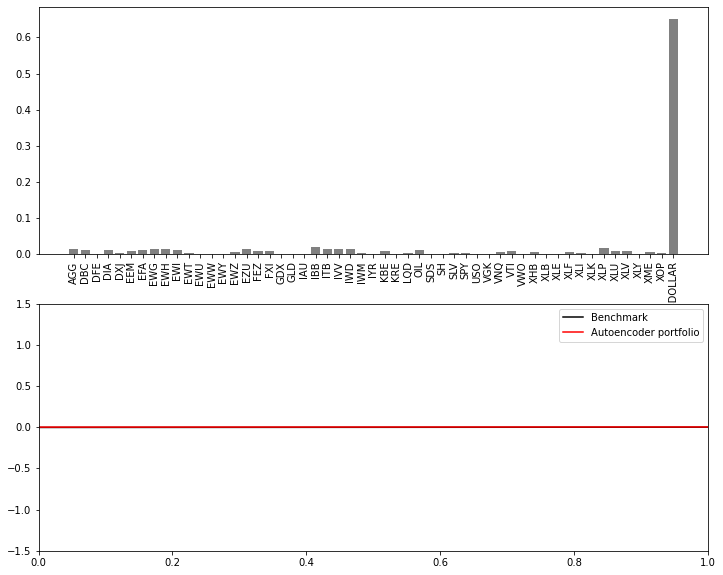

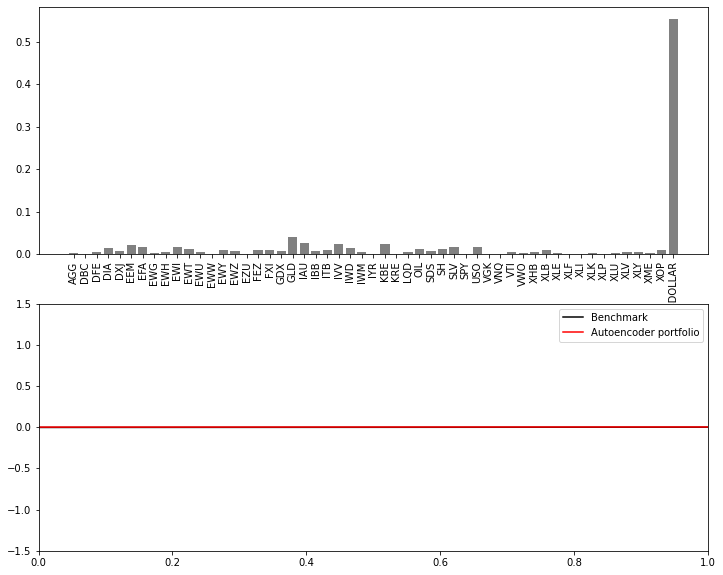

In [45]:
plot_results(result_equal, 
             result_ae, 
             actions_ae, 
             N_ASSETS,
             state.columns, 
             'Autoencoder portfolio', './images_etf/ae/', 'series')

# Making GIFs

In [46]:
import imageio
import glob
import os

In [47]:
name = 'decorr'

In [48]:
filenames = glob.glob('./images_etf/' + name + '/series*.jpg')

In [49]:
filenames.sort(key=lambda x: os.path.getmtime(x))

In [50]:
filenames

['./images_etf/decorr/series0.jpg',
 './images_etf/decorr/series1.jpg',
 './images_etf/decorr/series2.jpg',
 './images_etf/decorr/series3.jpg',
 './images_etf/decorr/series4.jpg',
 './images_etf/decorr/series5.jpg',
 './images_etf/decorr/series6.jpg',
 './images_etf/decorr/series7.jpg',
 './images_etf/decorr/series8.jpg',
 './images_etf/decorr/series9.jpg',
 './images_etf/decorr/series10.jpg',
 './images_etf/decorr/series11.jpg',
 './images_etf/decorr/series12.jpg']

In [51]:
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./images_etf/' + name + '_gif.gif', images, duration=0.5)

# Efficient Frontier

In [52]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [55]:
env.get_state(i, WINDOW_FIT, is_cov_matrix=False)

,AGG,DBC,DFE,DIA,DXJ,EEM,EFA,EWG,EWH,EWI,...,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XME,XOP,USDOLLAR
2015-07-08,0.002386,-0.004687,-0.020143,-0.014806,-0.058371,-0.034392,-0.023282,-0.015312,-0.052390,0.000711,...,-0.017487,-0.017995,-0.016334,-0.011197,-0.005293,-0.017161,-0.019043,-0.032342,-0.037400,8.451637e-07
2015-07-09,-0.003662,0.011772,0.015463,0.001486,0.016889,0.019304,0.016490,0.019622,0.043162,0.030561,...,0.007864,0.002431,-0.003907,0.000824,-0.011106,0.005414,0.004197,0.004456,0.019658,1.126884e-06
2015-07-10,-0.004226,0.004654,0.034575,0.012267,0.028107,0.025340,0.032766,0.049020,0.023710,0.055172,...,0.011910,0.010446,0.015935,0.011726,0.005381,0.013463,0.014498,0.000000,-0.012021,4.695345e-07
2015-07-13,-0.001476,0.000579,0.005368,0.012344,0.014024,0.006764,0.003733,-0.003461,0.015441,-0.009150,...,0.012175,0.011076,0.015203,0.009353,0.000465,0.008502,0.014420,0.029281,0.007805,7.512548e-07
2015-07-14,0.001663,-0.003472,0.004478,0.004065,0.007703,0.001809,0.008367,0.003126,0.000894,0.003298,...,0.002406,0.002739,0.003803,0.001612,-0.001396,0.010011,0.001269,-0.006466,0.030068,3.756271e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-16,0.004297,0.017411,0.014218,0.004808,-0.004309,0.020018,0.008825,0.015519,0.011524,0.009670,...,-0.002231,0.003515,0.011606,0.002284,0.015321,-0.002380,0.008122,0.052935,0.038199,1.238340e-05
2016-03-17,0.002094,0.011161,0.011323,0.008474,-0.006606,0.022041,0.007698,-0.000392,0.002071,0.000000,...,0.012075,0.021935,0.003671,0.006076,0.005506,-0.011628,0.001407,0.031857,0.017083,1.163275e-05
2016-03-18,0.000818,-0.000736,0.002310,0.004287,0.000459,0.005318,-0.001736,0.001568,0.006718,-0.005587,...,0.004419,0.003427,-0.003429,-0.006416,-0.013790,0.008145,-0.002809,0.008683,-0.001938,1.153880e-05
2016-03-21,-0.002178,0.002946,-0.003901,0.001821,0.004355,0.002057,-0.001565,-0.001174,0.004620,0.004815,...,-0.001760,0.005932,0.003441,0.000570,-0.001028,0.005835,0.000512,-0.000956,-0.002913,1.247677e-05


In [53]:
from scipy.optimize import minimize
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

print(opt_results)

NameError: name 'log_ret' is not defined

In [ ]:
opt_results.x

In [ ]:
get_ret_vol_sr(opt_results.x)

In [ ]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.3,100) # Change 100 to a lower number for slower computers!

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')



# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')